In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 24,
    'lines.linewidth': 5,    
    'lines.markersize': 6   
})

In [2]:
def apply_overlap(y_train, overlap_ratio):
    N, D = y_train.shape
    indices = np.arange(N)

    # Number of shared (overlap) indices
    n_overlap = int(overlap_ratio * N)

    # Select overlap indices common to all output functions
    shared_indices = np.random.choice(indices, size=n_overlap, replace=False)

    # Initialize all to NaN
    y_obs = np.full_like(y_train, np.nan)

    # Set the shared overlap values
    y_obs[shared_indices, :] = y_train[shared_indices, :]

    # Remaining indices to distribute uniquely across each output
    remaining_indices = np.setdiff1d(indices, shared_indices)

    n_unique_per_output = (N - n_overlap) // D

    for d in range(D):
        # Randomly assign unique indices to each output from remaining pool
        if d < D - 1:
            chosen = np.random.choice(remaining_indices, size=n_unique_per_output, replace=False)
            remaining_indices = np.setdiff1d(remaining_indices, chosen)
        else:
            # Assign all remaining indices to the last output (in case of uneven division)
            chosen = remaining_indices
        y_obs[chosen, d] = y_train[chosen, d]

    return y_obs

## MOGP

[[1.       0.9     ]
 [0.9      1.000096]]


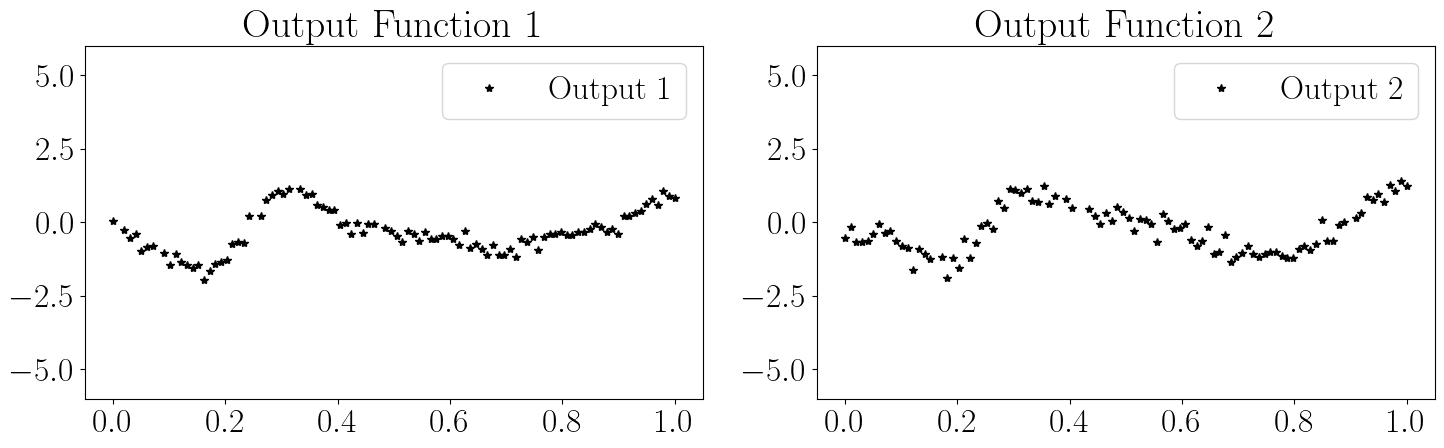

In [3]:
np.random.seed(42)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

A = np.array([[1, 0], 
              [0.9, 0.436]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.09])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

# indices_025 = np.where((x_train >= 0.20) & (x_train <= 0.30))[0]
# outlier_indices_025 = np.random.choice(indices_025, 1, replace=False)
# y_train[outlier_indices_025, 0] = -5

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

Optimized length_scale: 0.0842, noise: 0.049710
Optimized A: [[ 0.79228494 -0.00108693]
 [ 0.72182022  0.35025994]]
Optimized B: 
[[0.62771661 0.57150659]
 [0.57150659 0.64370646]]


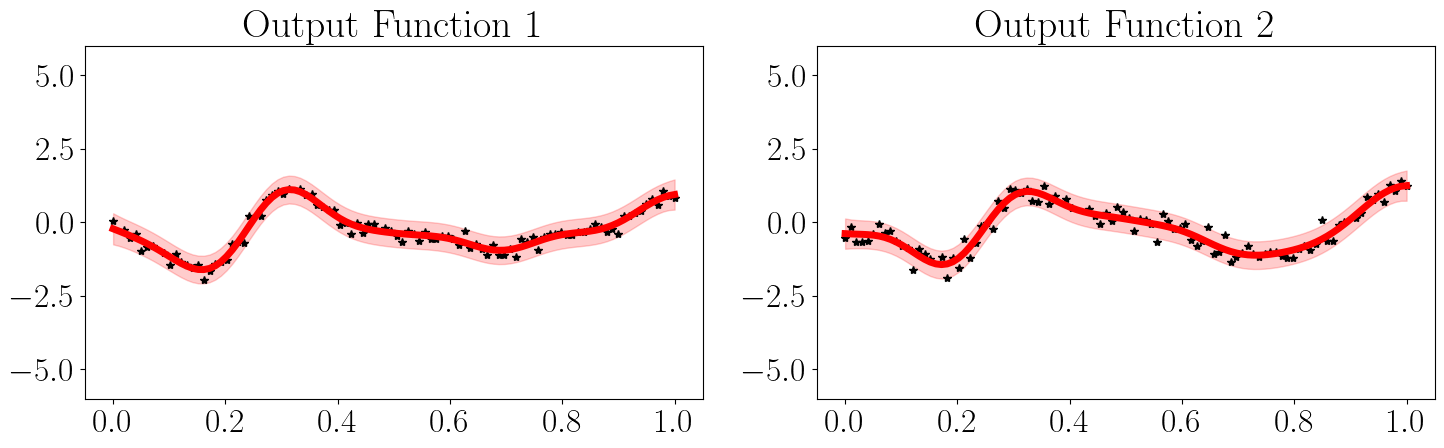

In [4]:
# Instantiate and train
# mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

## Original IMQ - MORCGP

[[1.999396 1.200486]
 [1.200486 1.000642]]


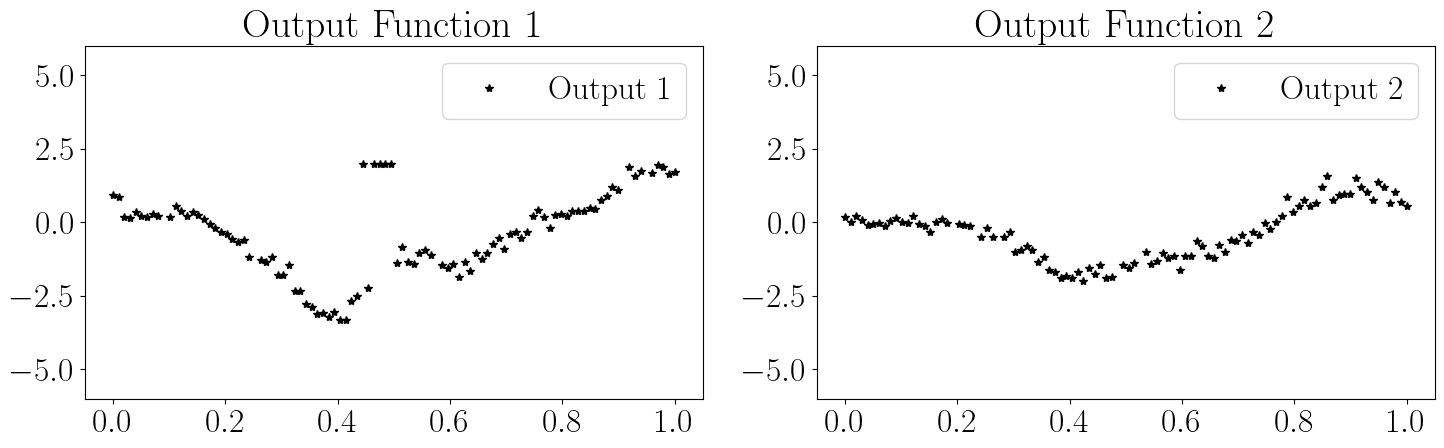

In [5]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9
epsilons = np.array([0.05, 0])

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(epsilons[0] * n_points), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

-374.49820432900884
-374.4982078594414
-374.4982007344535
-374.4982042892826
-374.4982037886933
-374.4982045971048
-374.49820467189676
-374.4982040961456
-127.87951590323483
-127.87951634845469
-127.87951495141155
-127.879515863519
-127.87951580543745
-127.87951600318286
-127.87951604591973
-127.87951582036057
-103.77453629735065
-103.77453651093107
-103.7745356773283
-103.77453628279176
-103.77453624775279
-103.77453636620132
-103.77453639697961
-103.77453623961938
-82.32823671599677
-82.32823671523641
-82.32823649908137
-82.32823671608722
-82.32823670535197
-82.32823674384386
-82.32823677234992
-82.32823670722914
-77.90569693032126
-77.90569693024713
-77.9056968648574
-77.90569692694157
-77.90569692339469
-77.90569695155533
-77.90569698145237
-77.9056969326045
-76.61335704835092
-76.61335703093214
-76.6133570489208
-76.61335704748129
-76.61335704668653
-76.61335706355656
-76.61335709631355
-76.61335706497754
-75.28831711807612
-75.28831710736932
-75.28831716593604
-75.28831711882091


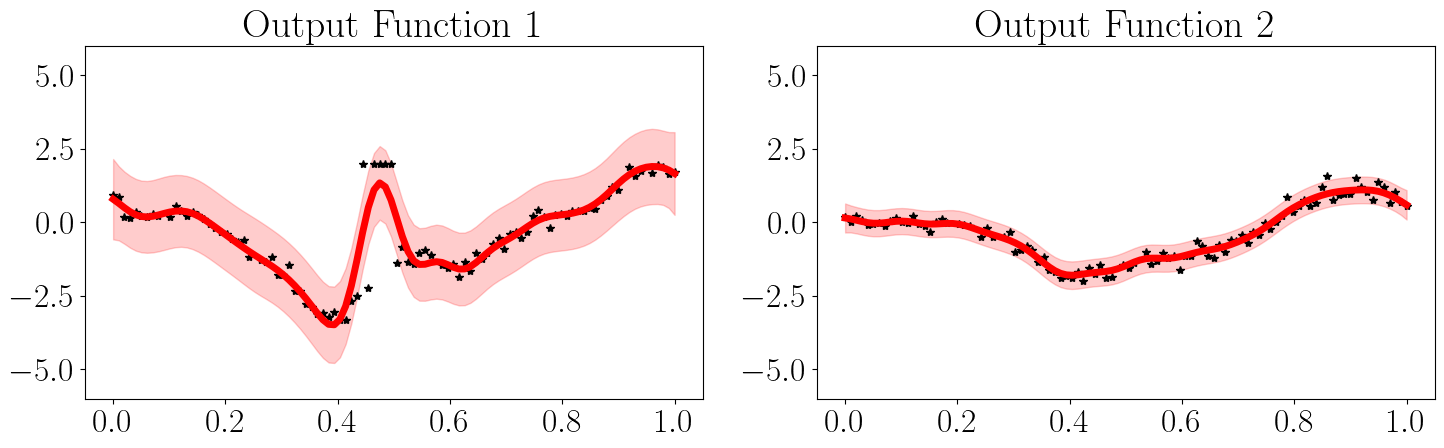

In [6]:
# Instantiate and train
morcgp = MORCGPRegressor_PM(mean = 0, length_scale=0.1, noise = noise, A=A, epsilons=epsilons)
# morcgp = MORCGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

## MORCGP - cross channel predictive

[[1.999396 1.200486]
 [1.200486 1.000642]]


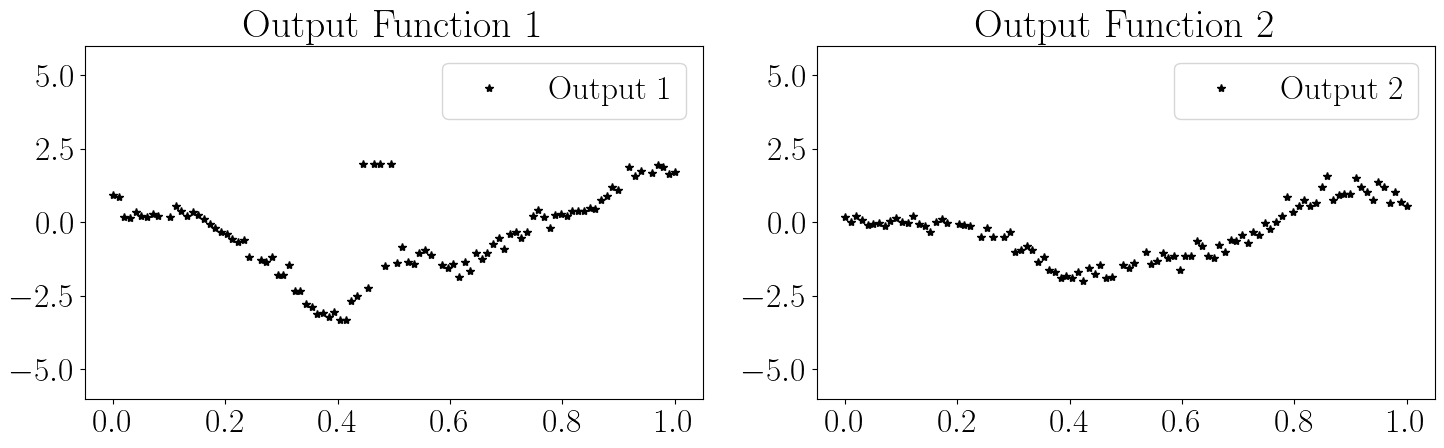

In [74]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [75]:
# Instantiate and train
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_B = mogp.B
optim_noise = mogp.noise

-147.73323846490533
-147.73323952445284
-147.7332369277534
-147.7332384899633
-147.73323860309145
-147.73323871762153
-147.73323839700512
-147.7332380016995
-56.536649869333665
-56.53664989345855
-56.53664957839323
-56.53664988890769
-56.536649980082395
-56.536649902820734
-56.53664987447864
-56.53664980664802
-51.36529265593801
-51.36529264743251
-51.36529249523876
-51.36529267239896
-51.36529272695343
-51.36529266760766
-51.365292670335805
-51.365292640121744
-48.29472294141662
-48.29472290735527
-48.294722910102344
-48.294722948677496
-48.29472294868142
-48.29472295262791
-48.29472297278478
-48.29472295482616
-47.61358270747639
-47.613582680155254
-47.61358270875974
-47.613582712850786
-47.613582696258995
-47.61358271326007
-47.61358273876454
-47.6135827335082
-46.68321774126909
-46.68321775115635
-46.68321777816107
-46.68321774993705
-46.683217721271916
-46.68321775484179
-46.68321778547747
-46.68321777333407
-178.54265993842964
-178.54266057173157
-178.54265920426985
-178.54266000

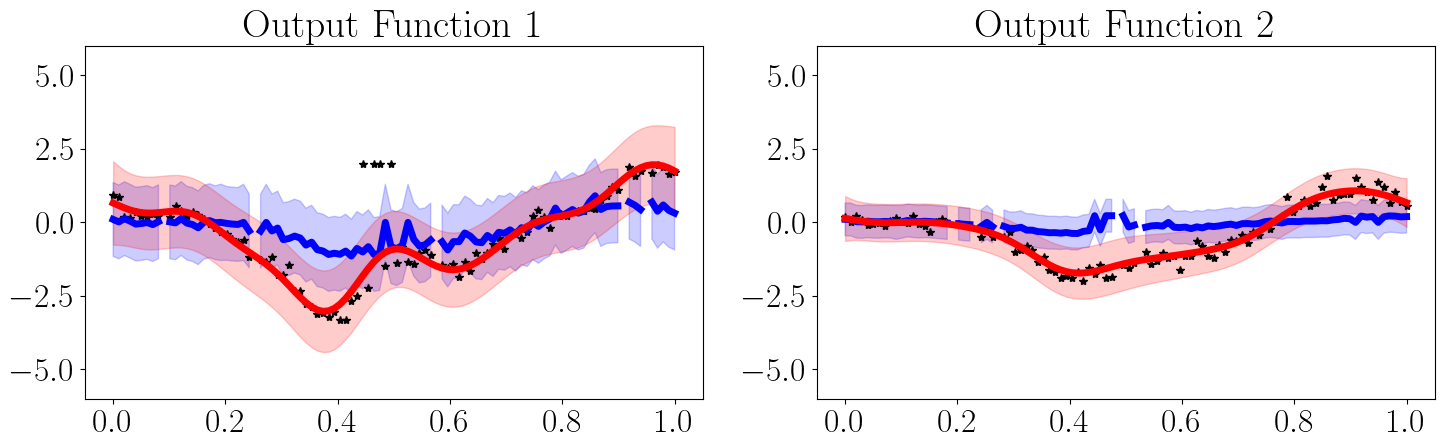

In [76]:
# Instantiate and train
morcgp = MORCGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
# morcgp = MORCGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, B_weighted=optim_B, noise_weighted=optim_noise)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

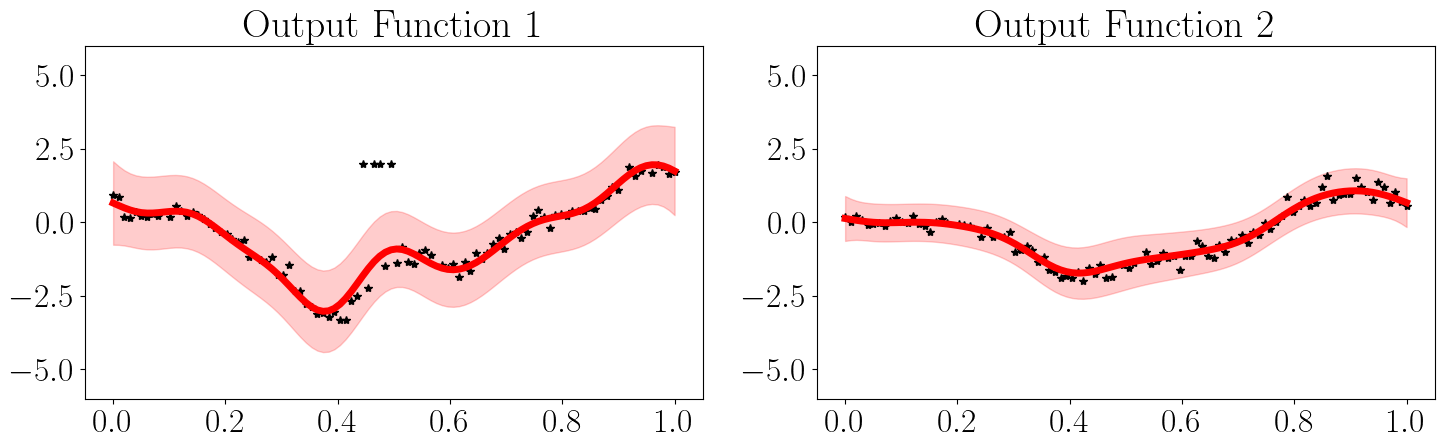

In [78]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), ((morcgp.weights_01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

## Fixed weights

[[1.999396 1.200486]
 [1.200486 1.000642]]


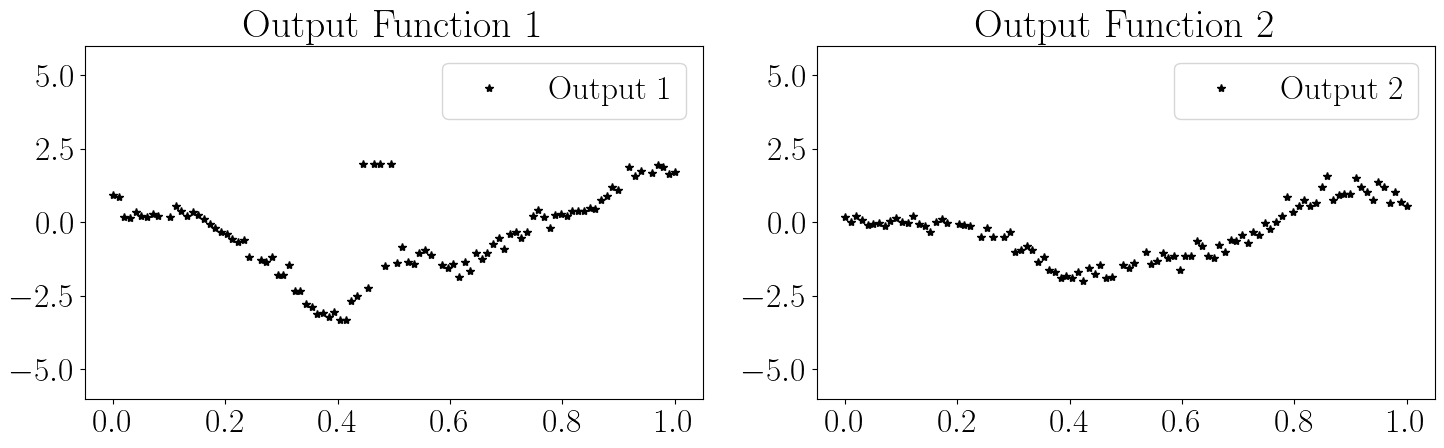

In [3]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

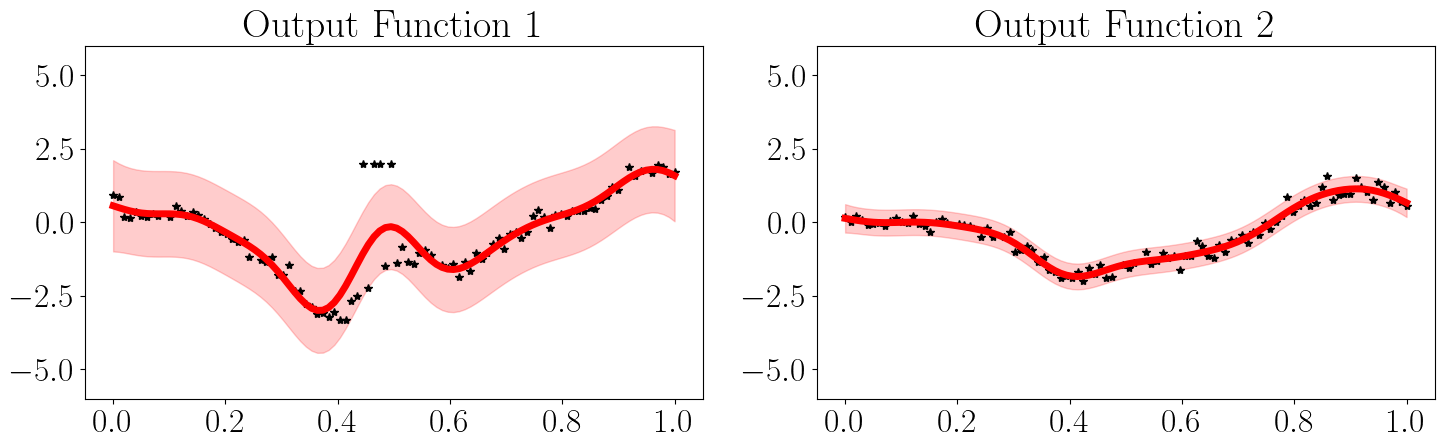

In [4]:
# Instantiate and train
# mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

-61.398132626291726
-61.39813262060429
-61.39813290049639
-61.398132718466876
-61.39813262957476
-61.398132617189866
-61.39813263007484
-61.3981326553924
-47.81929761764567
-47.819297648179756
-47.81929755575025
-47.819297566654676
-47.819297601992986
-47.81929761464016
-47.8192976356451
-47.81929764302767
-46.97909388269163
-46.97909387863918
-46.97909390197402
-46.97909389108033
-46.97909387501774
-46.97909388433274
-46.97909389498058
-46.97909388764546
-46.895490879226784
-46.89549087544743
-46.89549088026371
-46.89549088392231
-46.89549087253443
-46.89549088290858
-46.89549088769845
-46.89549087391265
Optimized length_scale: 0.0808
Optimized noise: [0.20659881 0.03463075]
Optimized A: [[ 1.46538358 -0.06847276]
 [ 0.42228482  0.31784667]]
Optimized B: 
[[2.15203756 0.5970454 ]
 [0.5970454  0.27935097]]


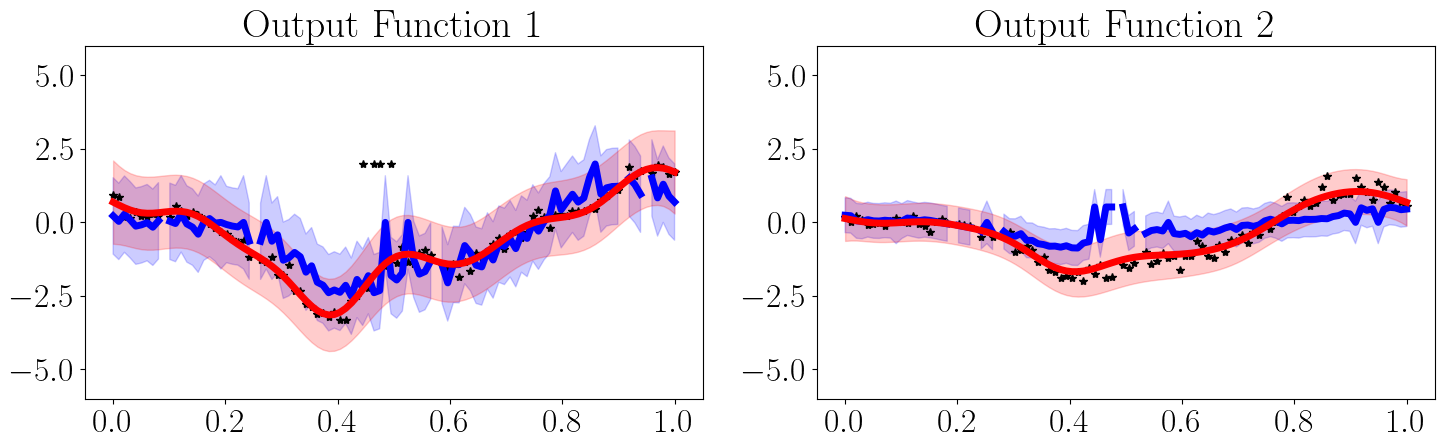

In [5]:
# Instantiate and train
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train, B_weighted=optim_B, noise_weighted=optim_noise)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

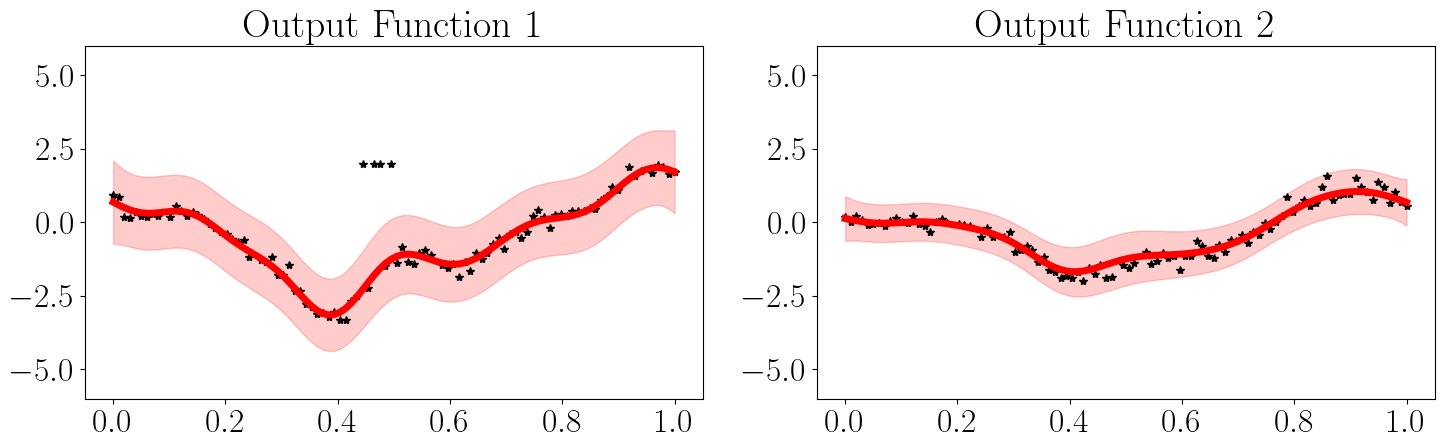

In [6]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), ((morcgp.w01.reshape(2,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

## Plot

502
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


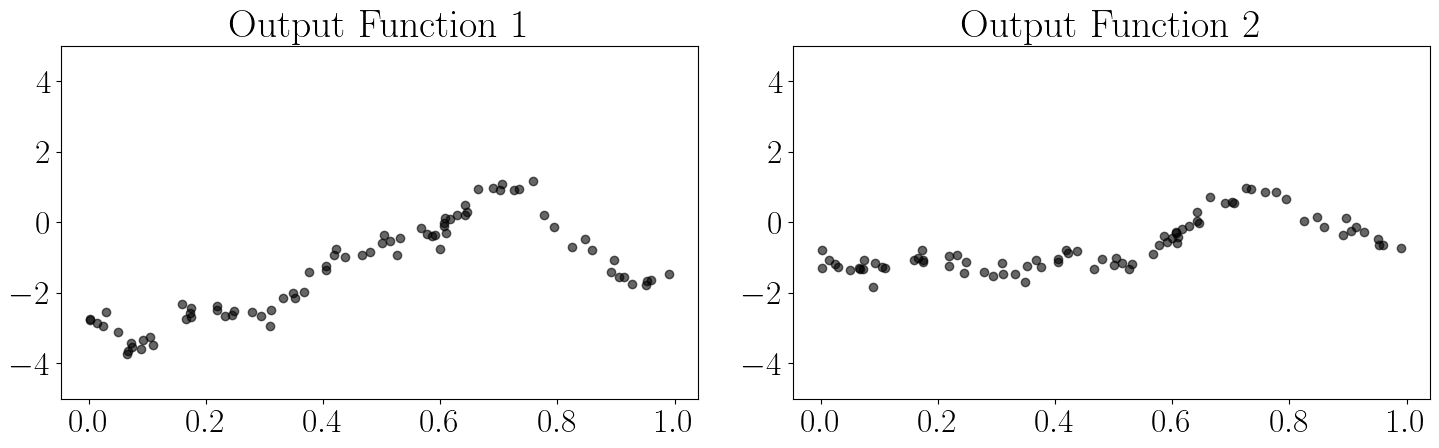

504
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


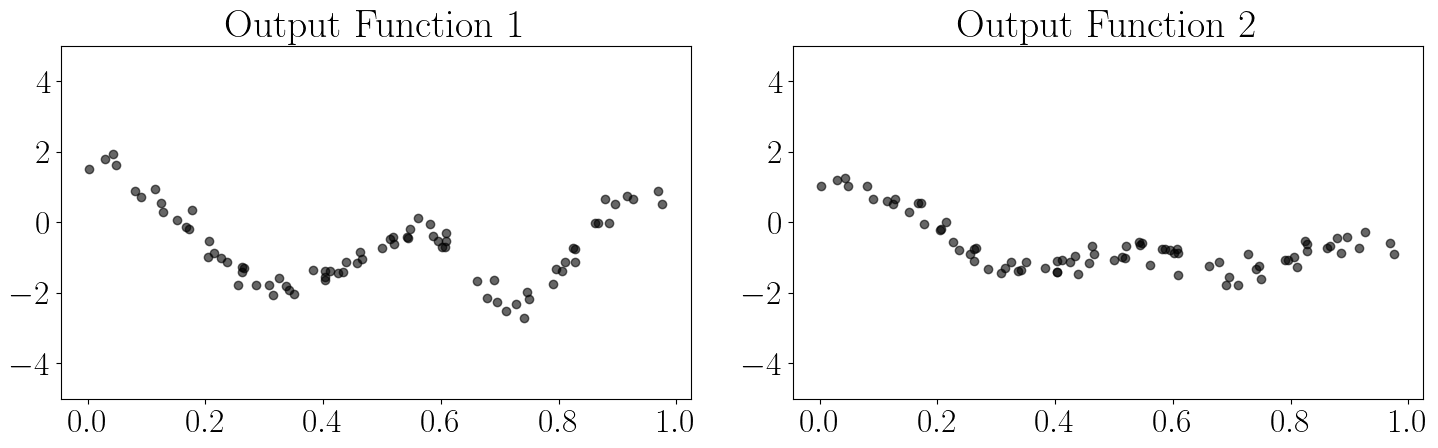

507
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


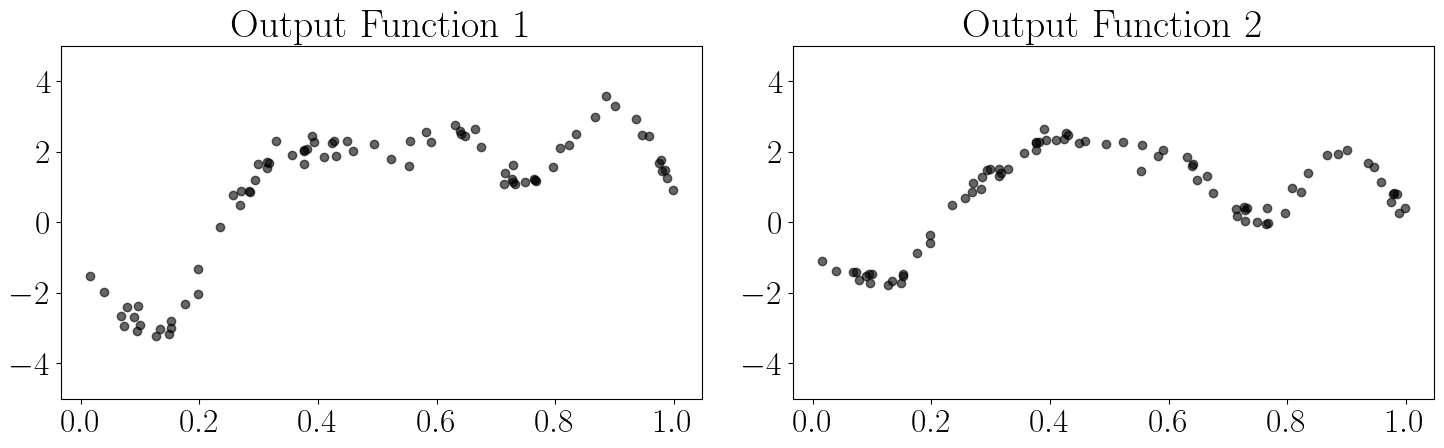

510
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


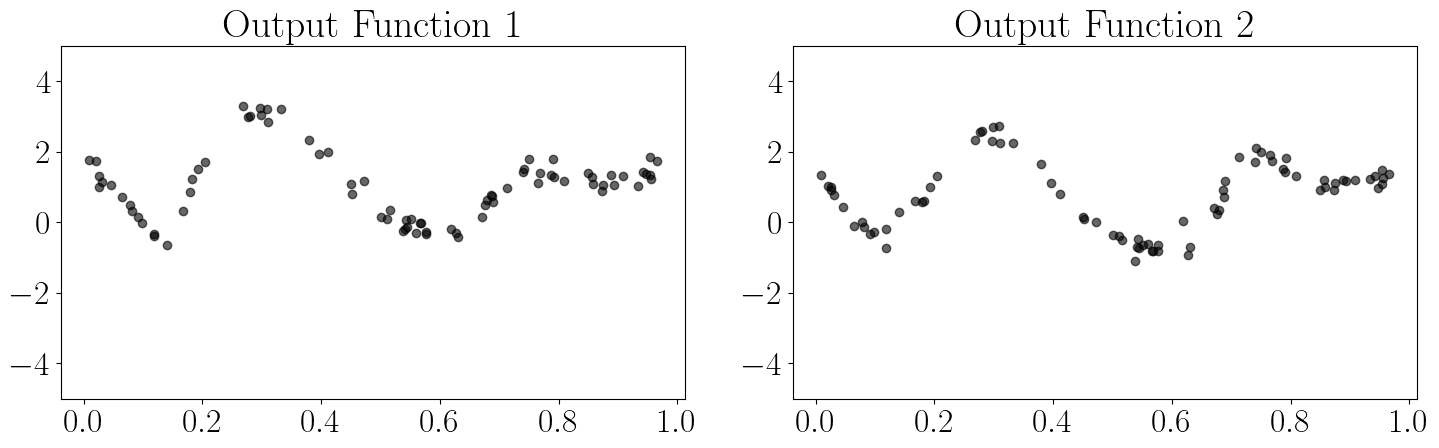

512
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


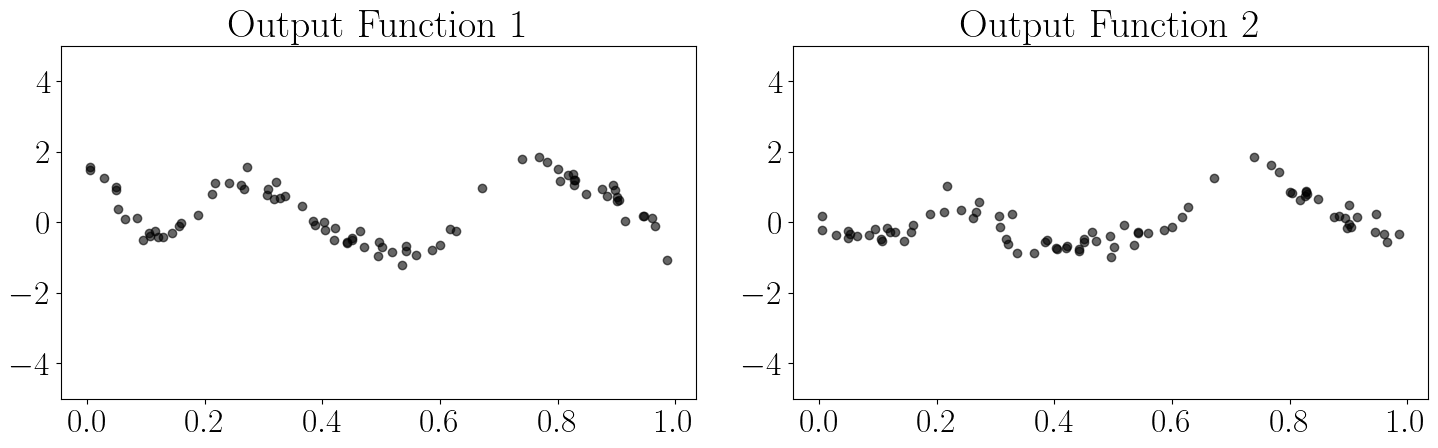

516
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


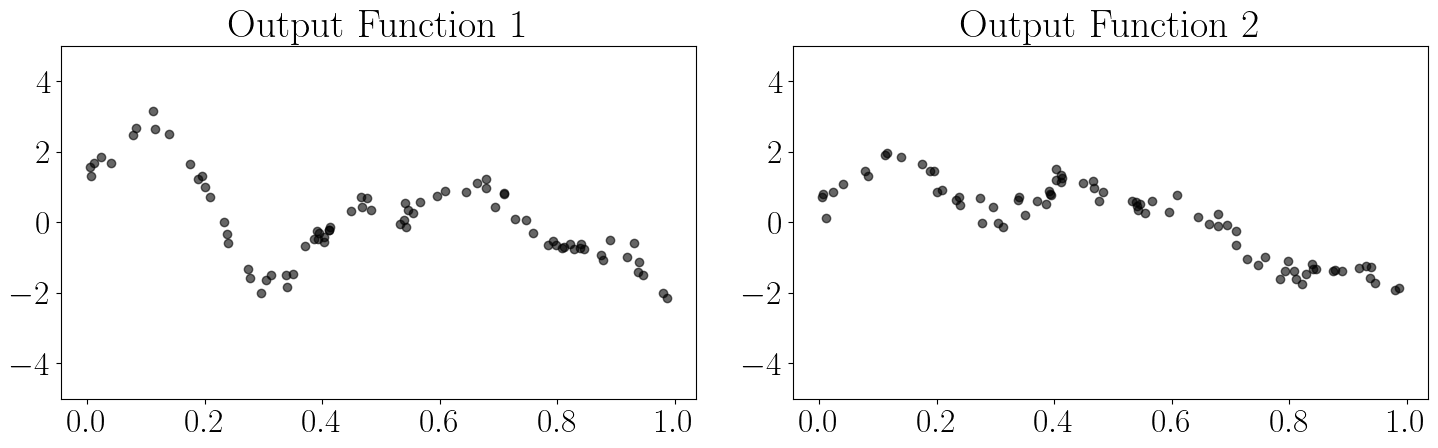

521
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


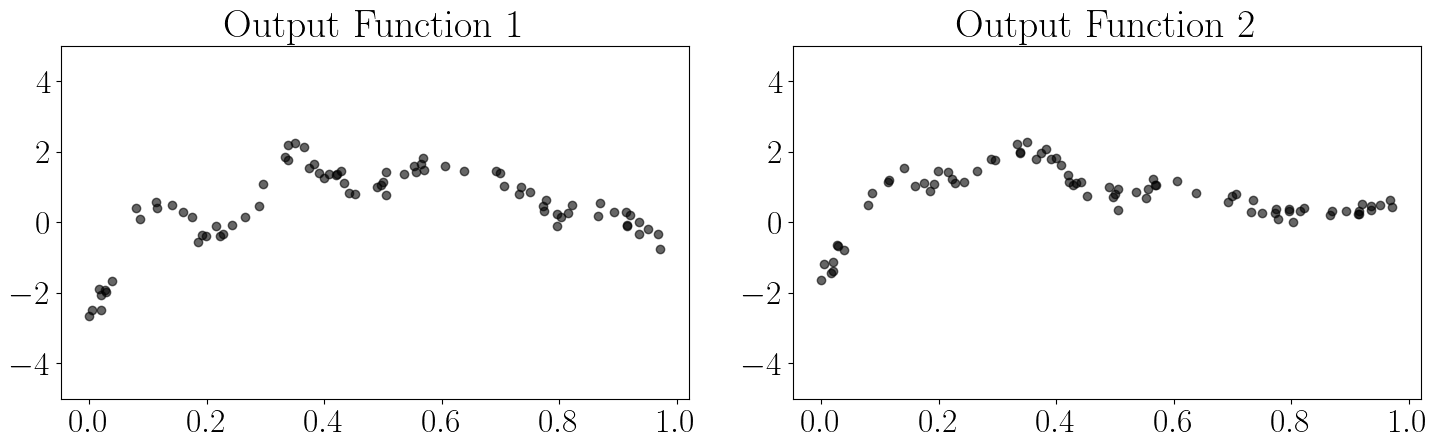

522
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


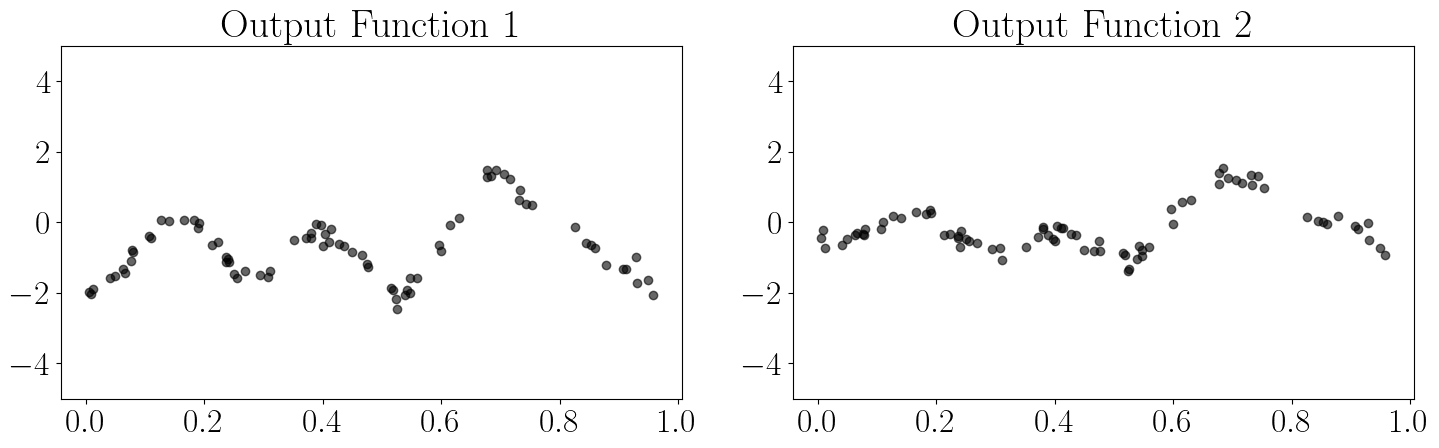

529
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


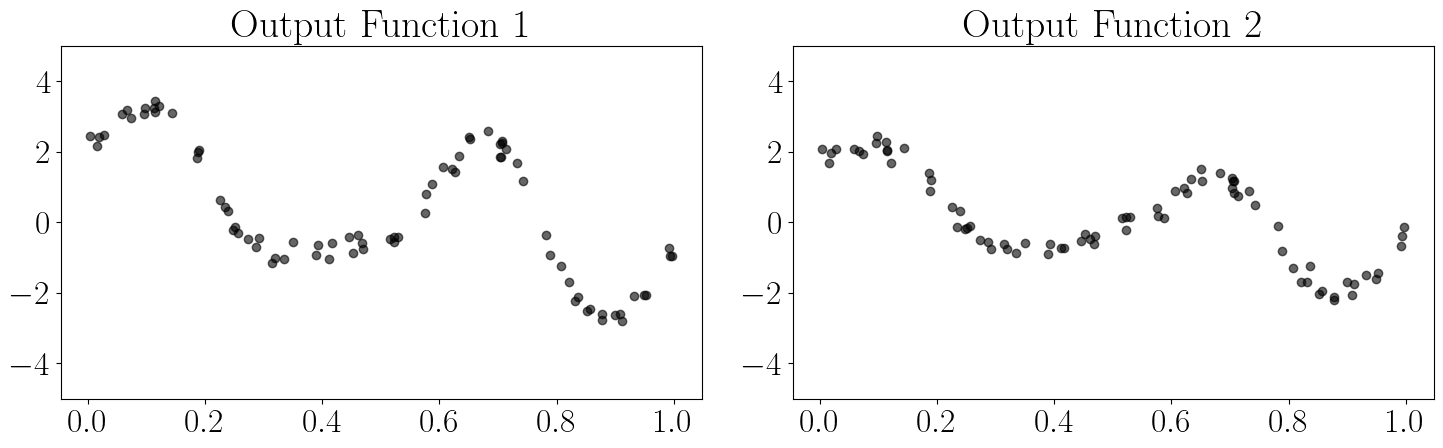

530
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


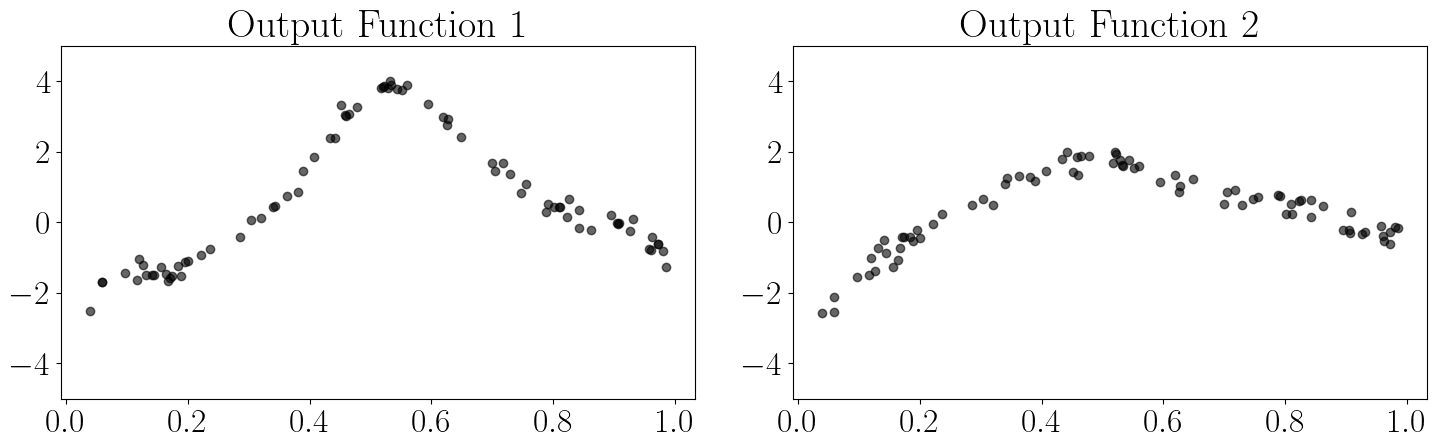

532
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


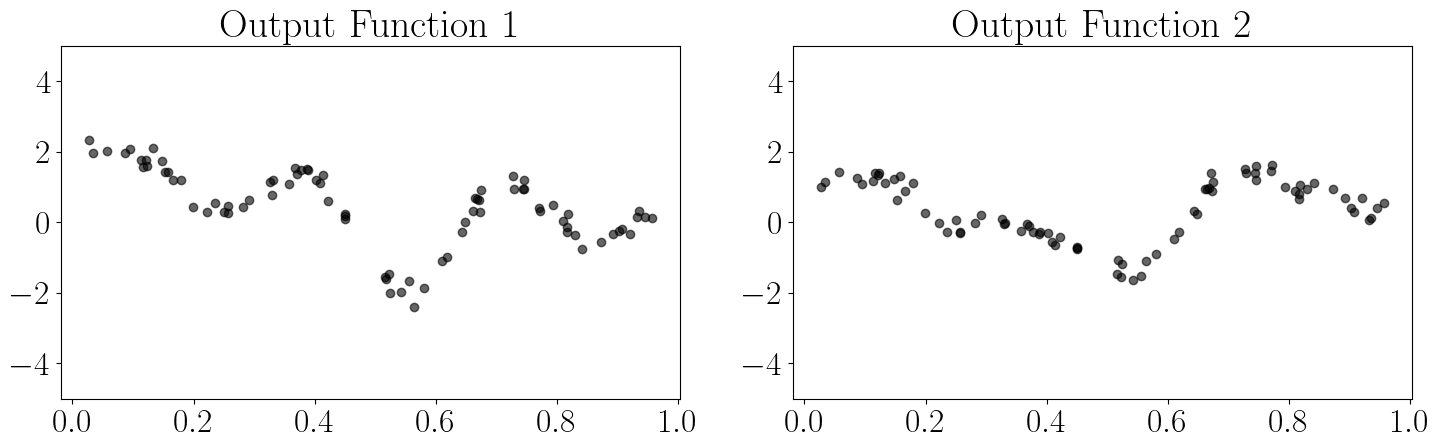

545
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


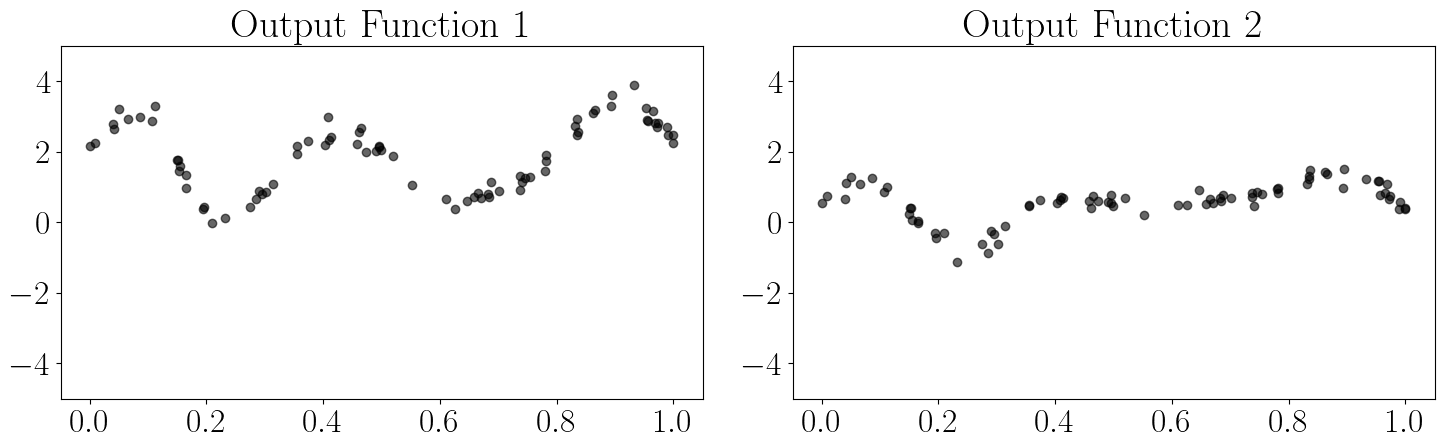

546
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


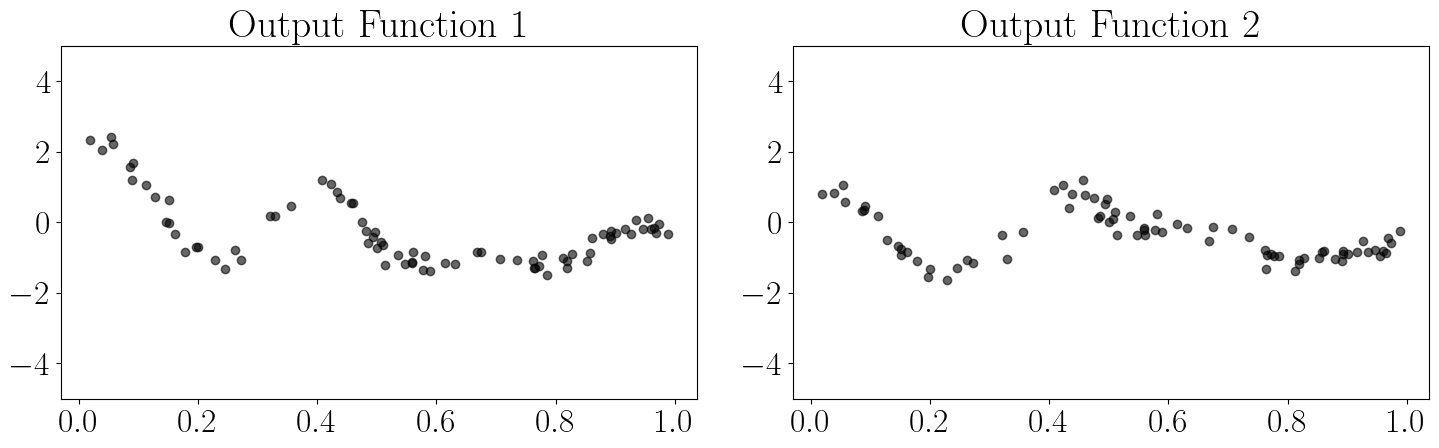

564
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


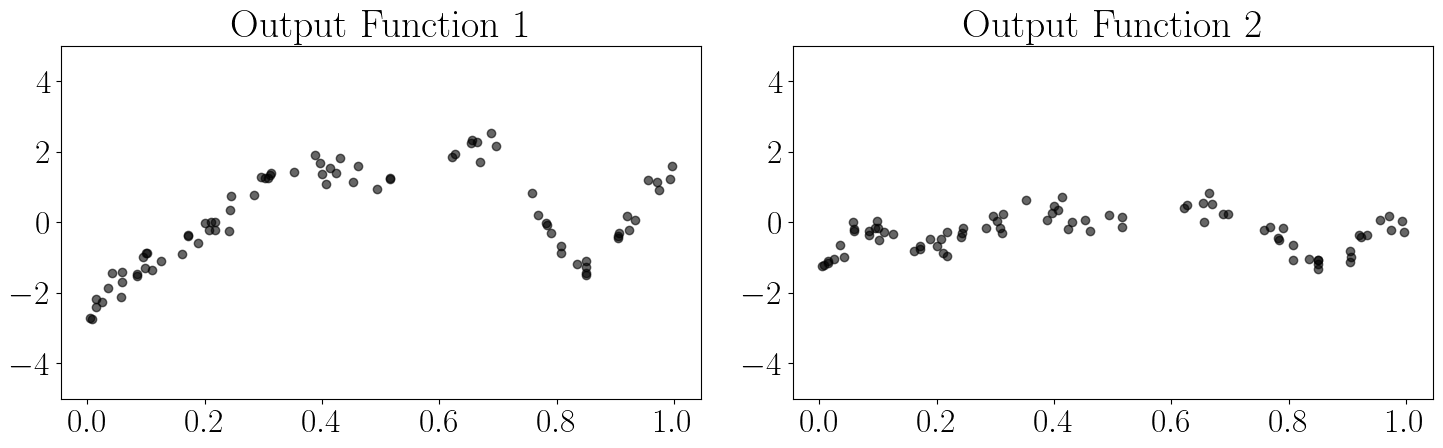

566
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


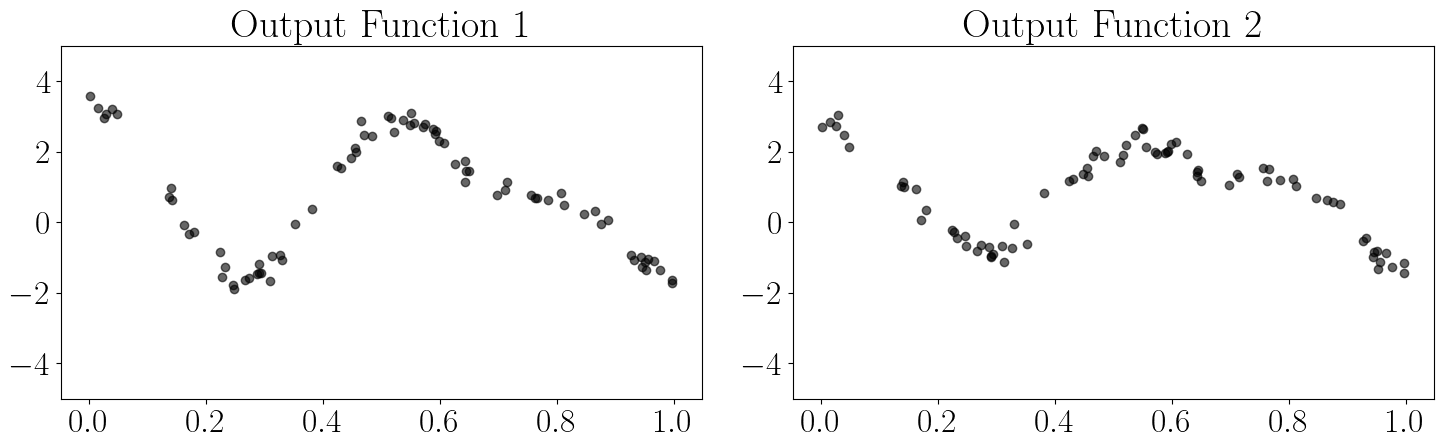

569
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


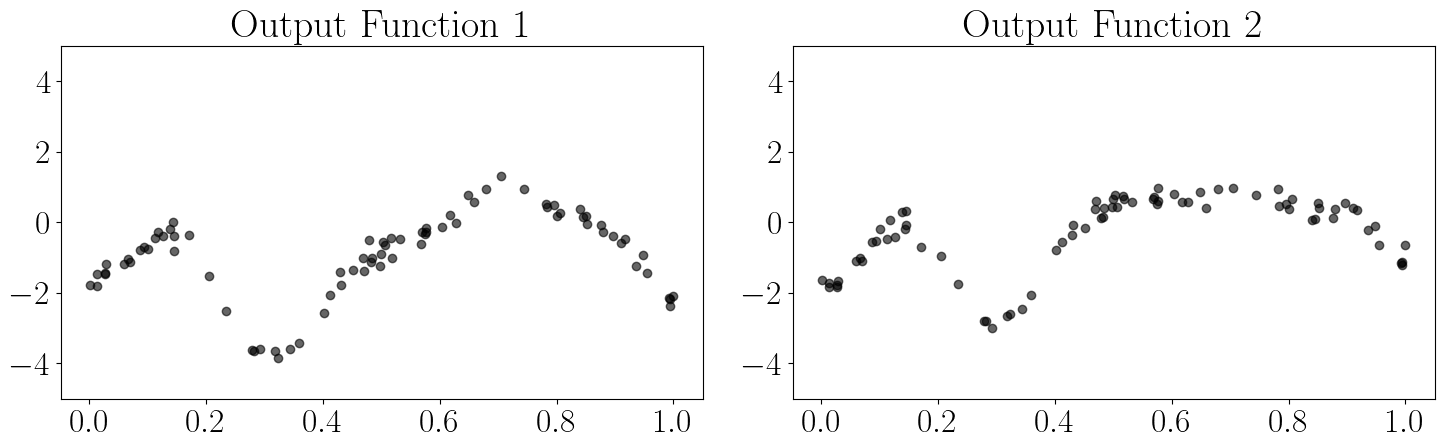

572
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


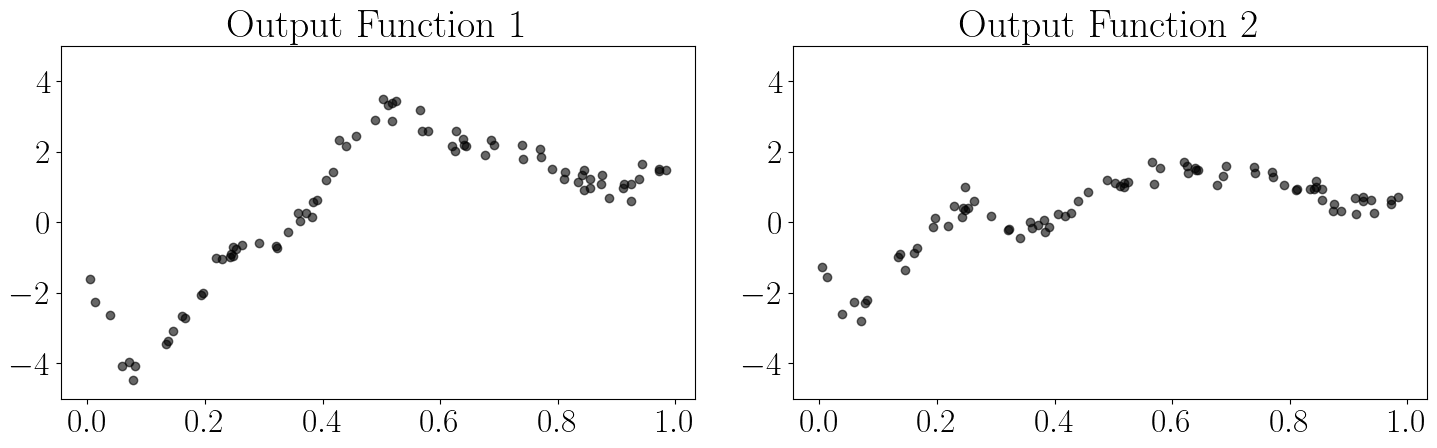

575
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


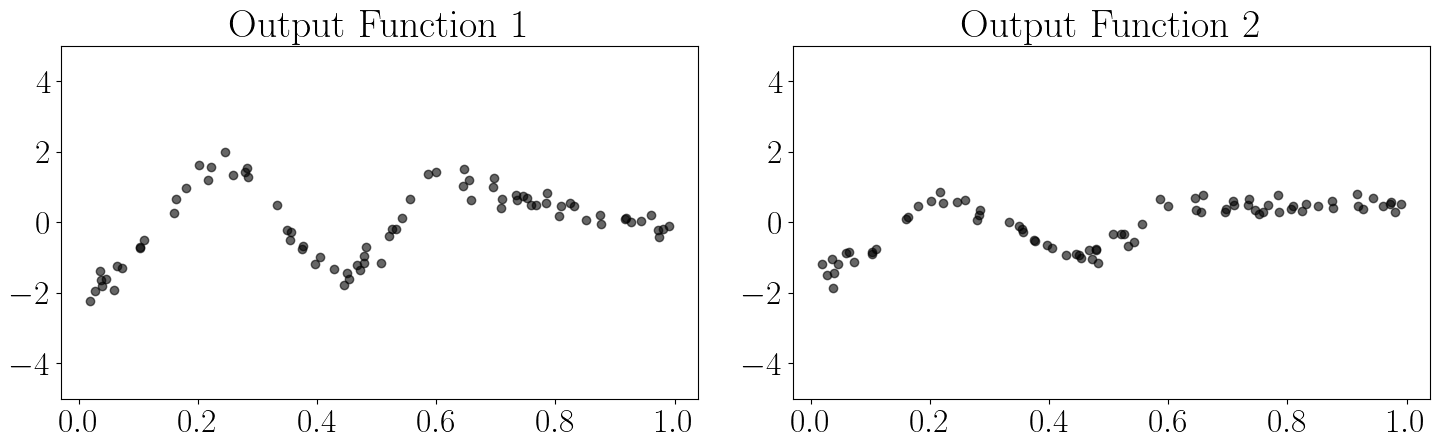

577
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


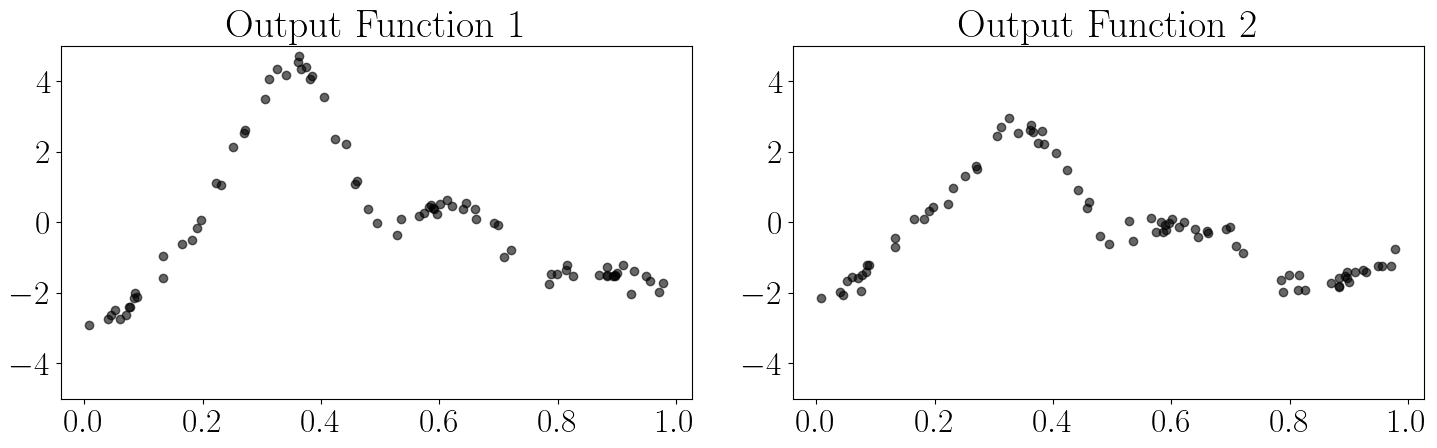

590
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


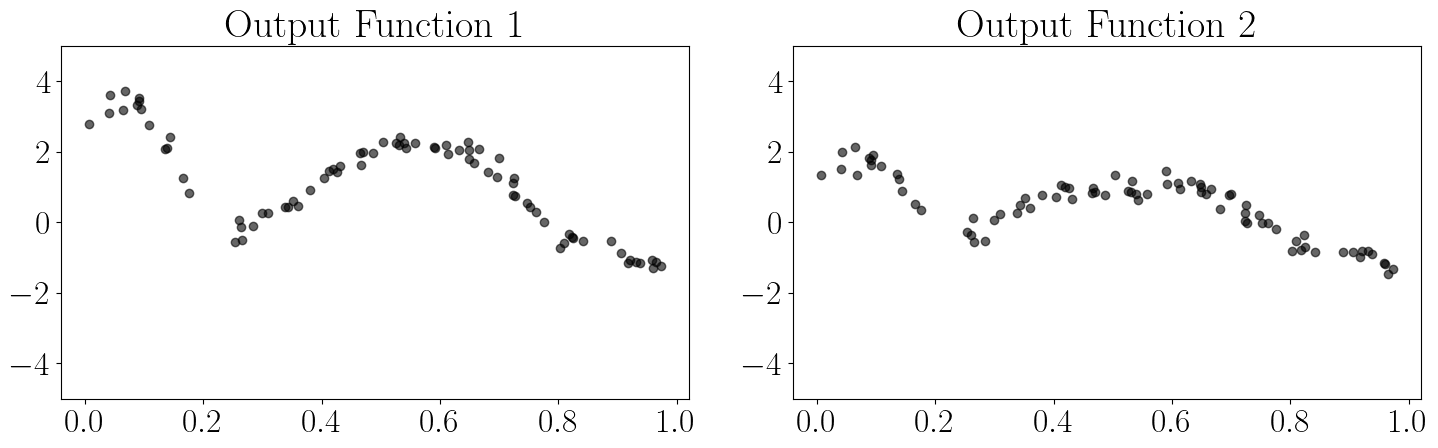

593
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


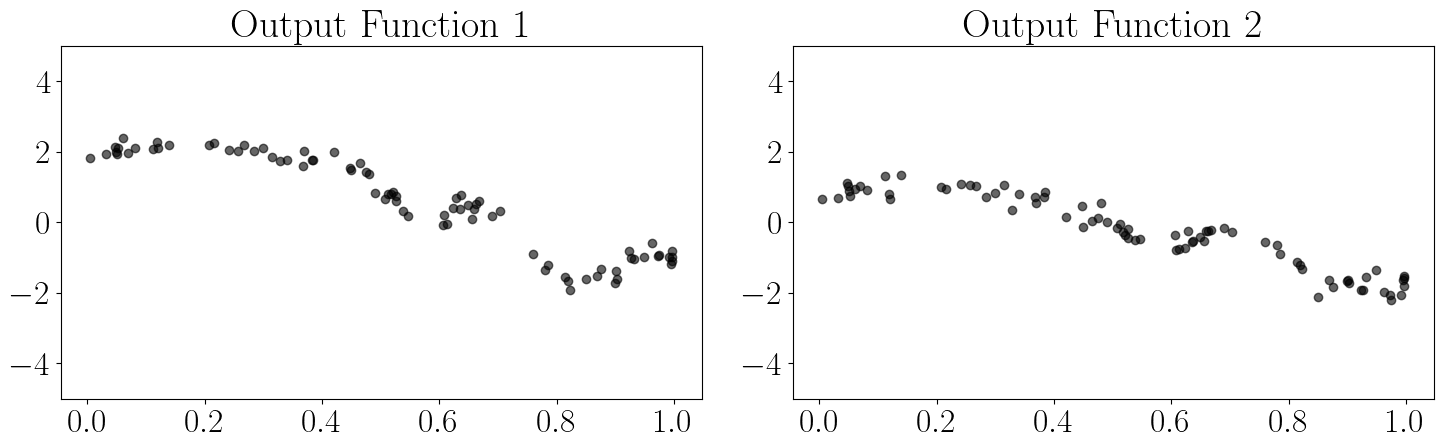

598
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


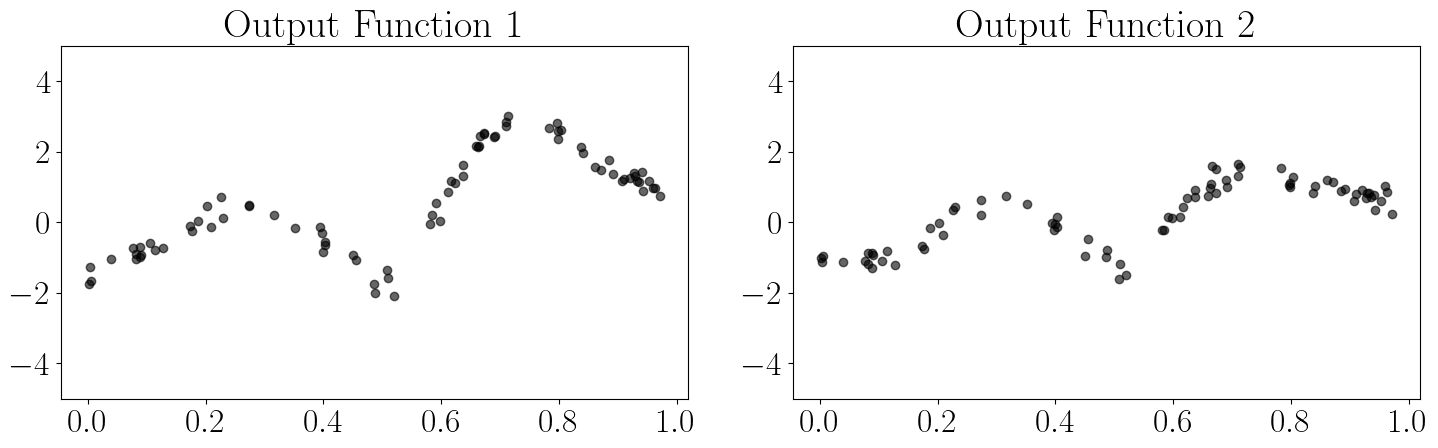

601
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


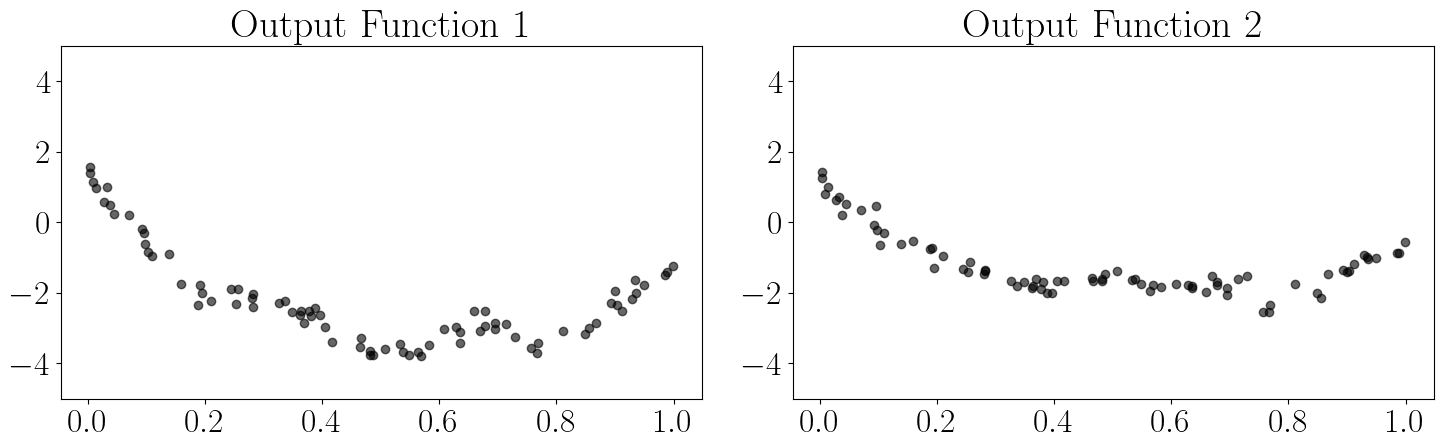

602
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


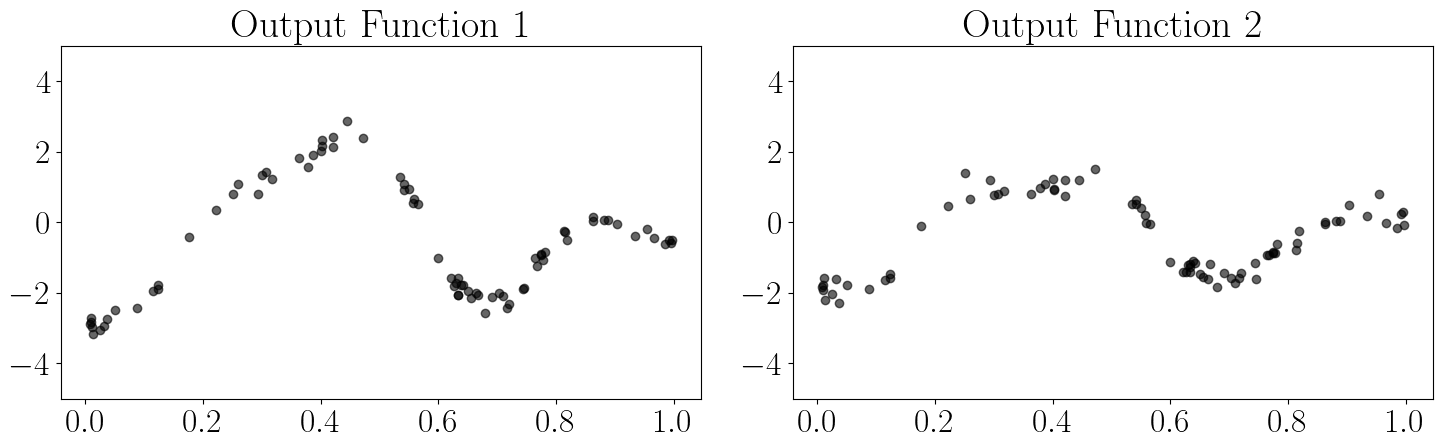

603
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


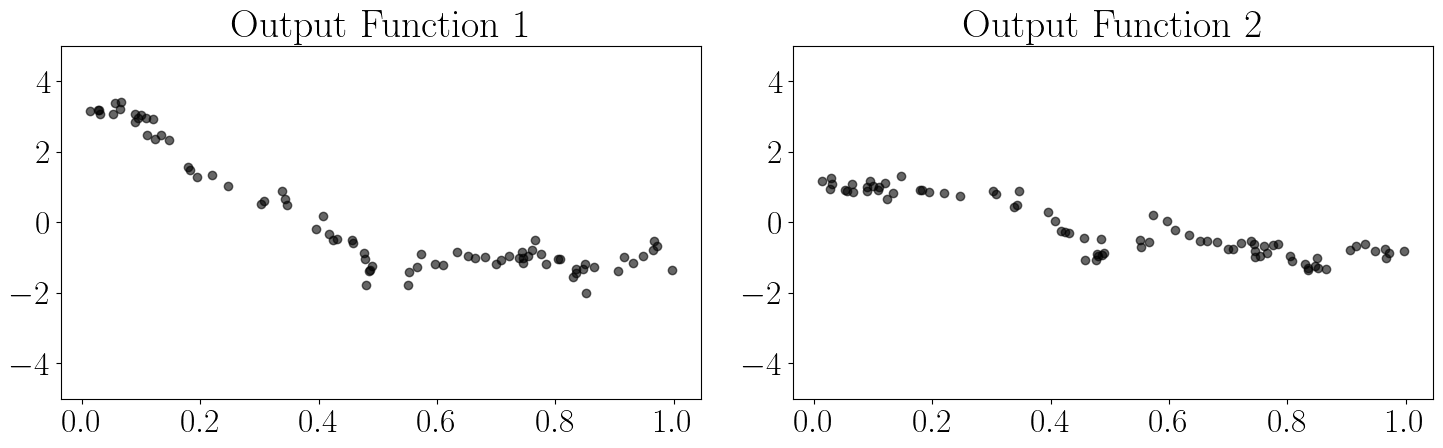

605
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


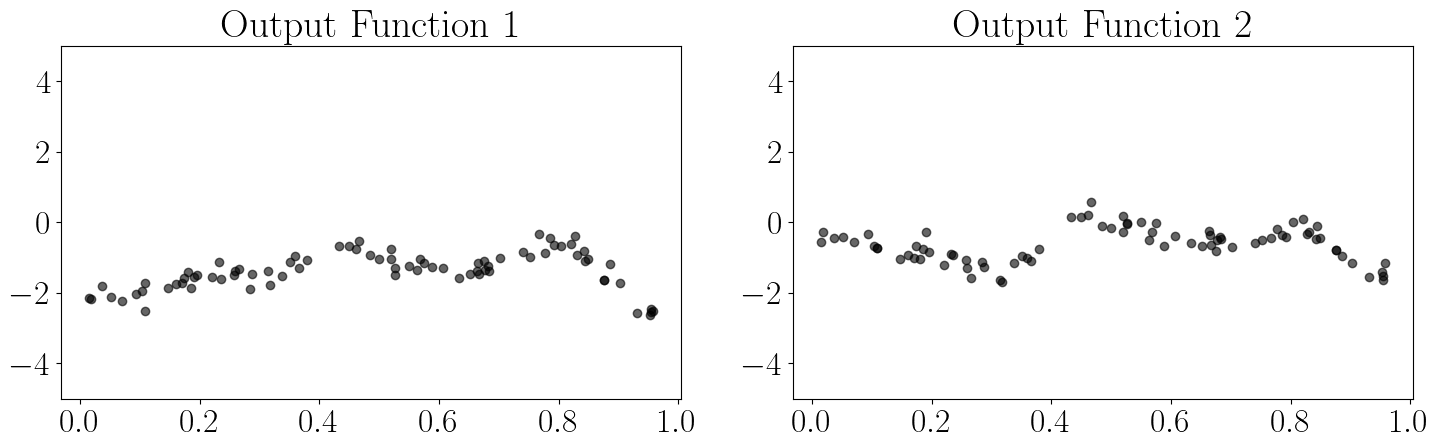

606
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


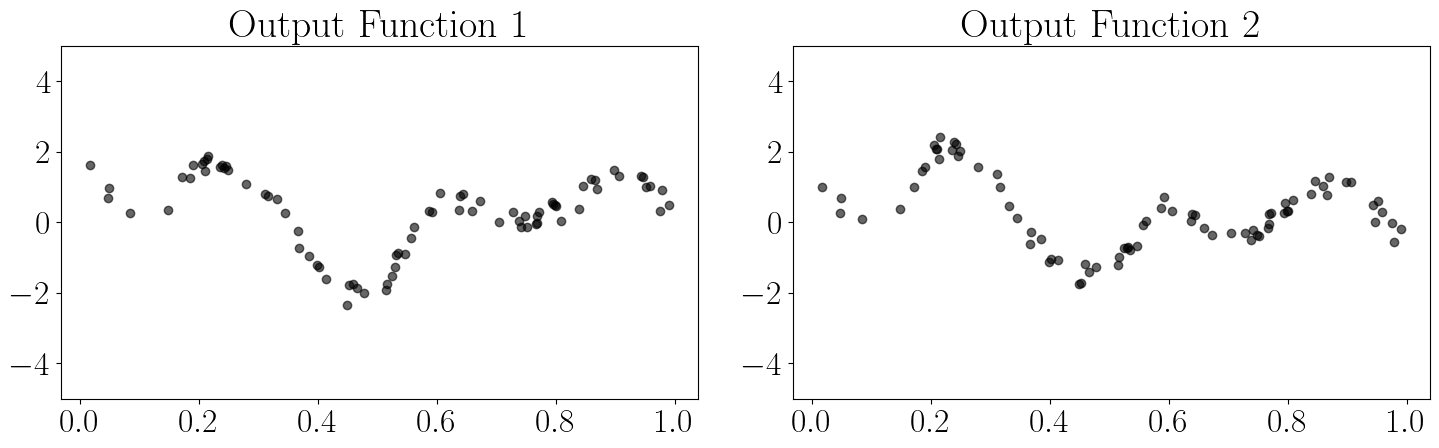

607
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


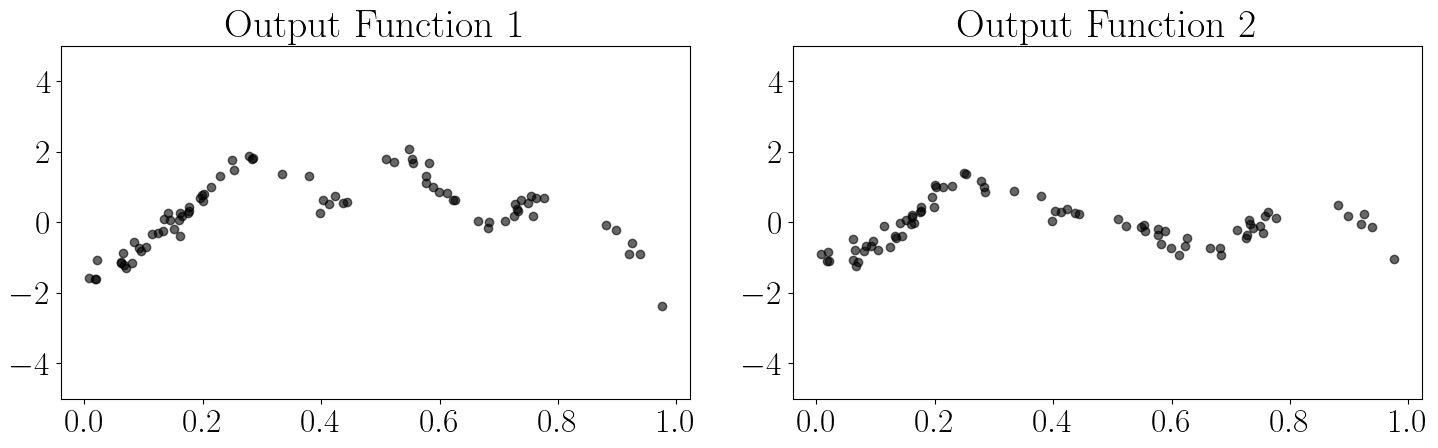

608
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


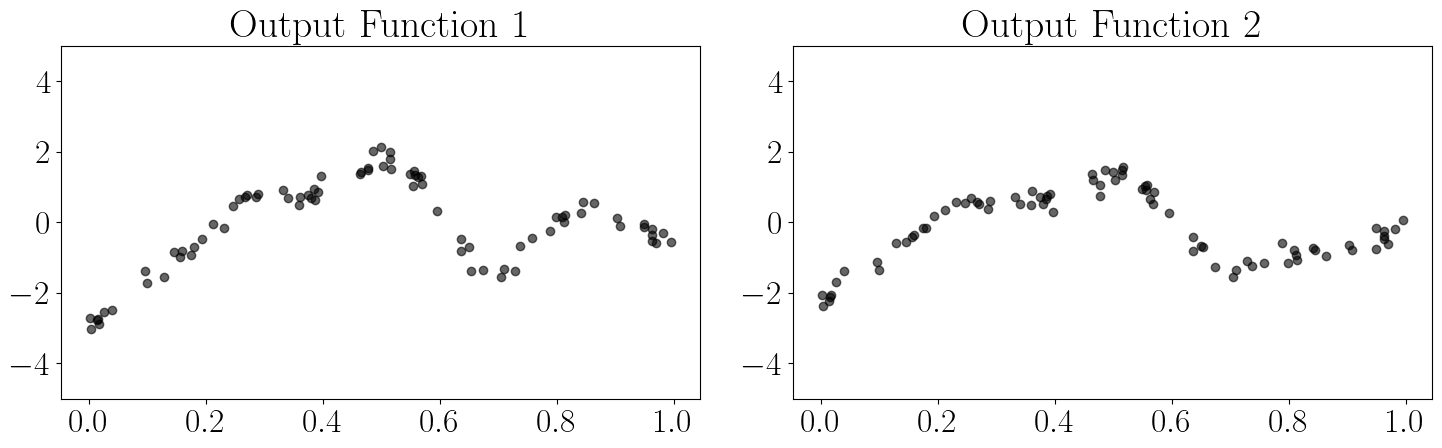

615
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


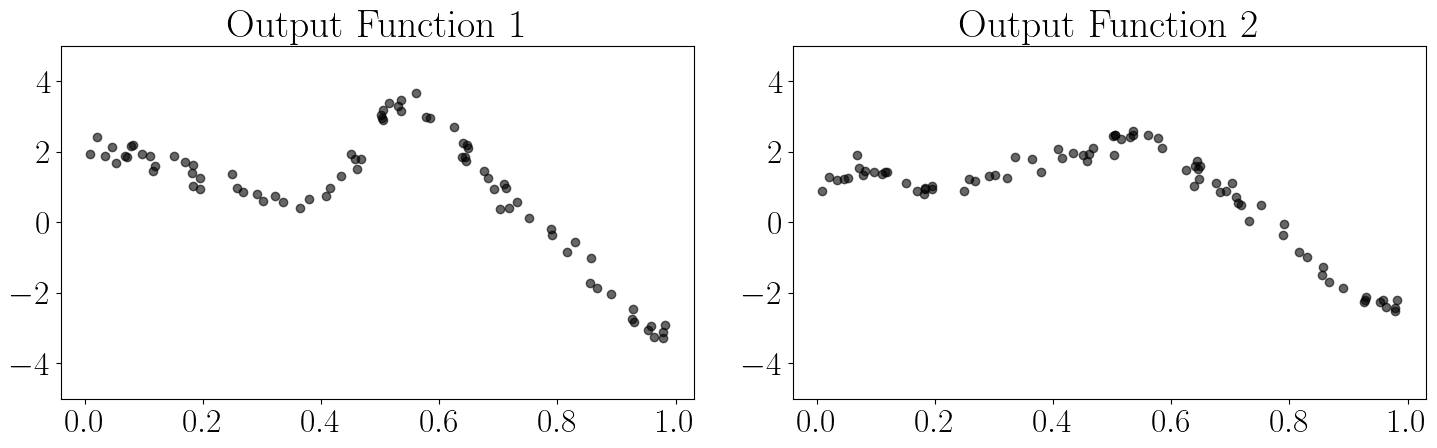

617
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


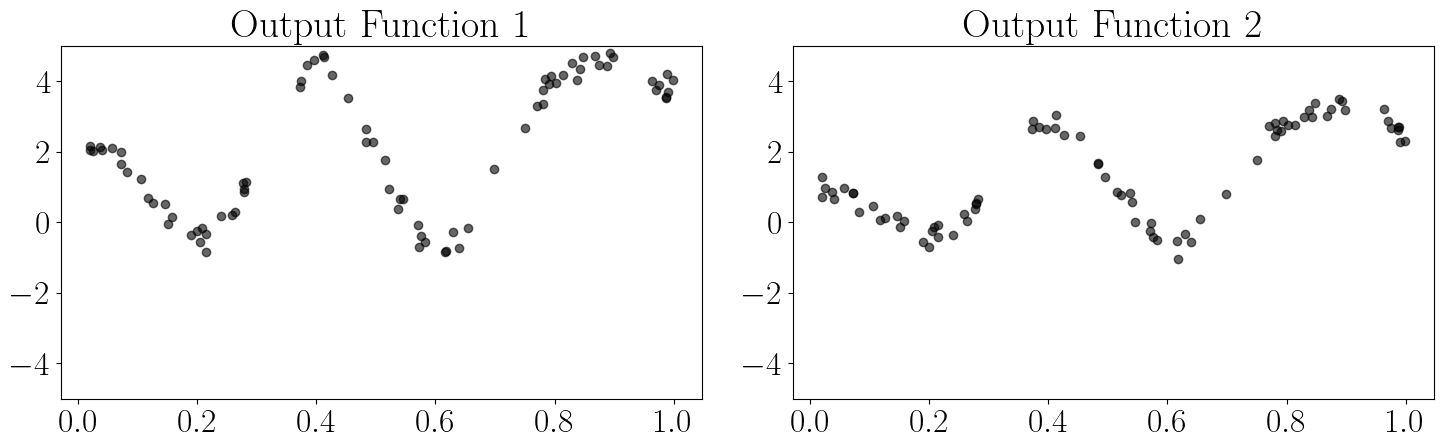

619
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


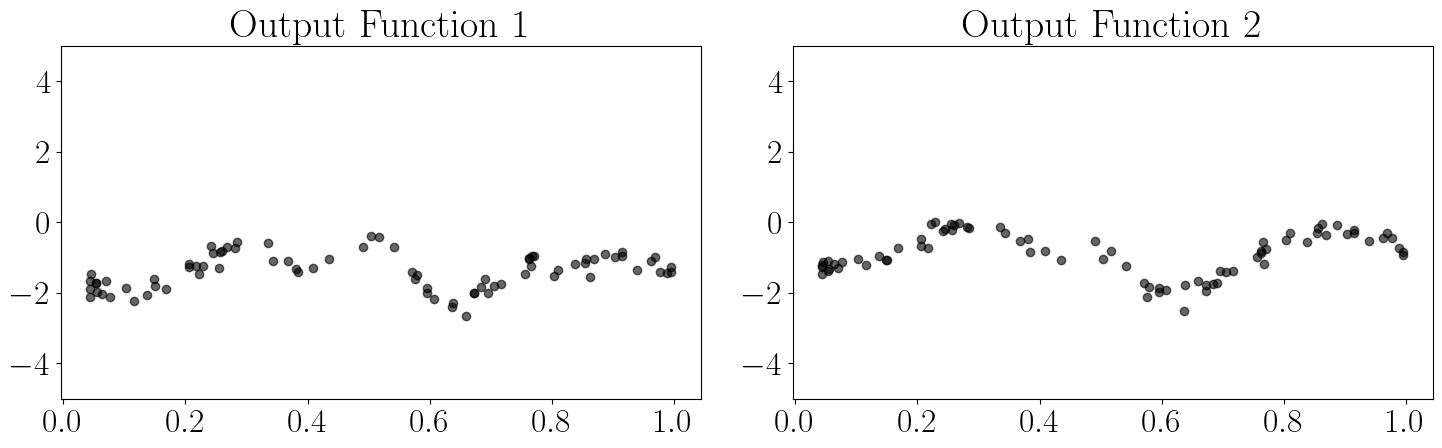

620
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


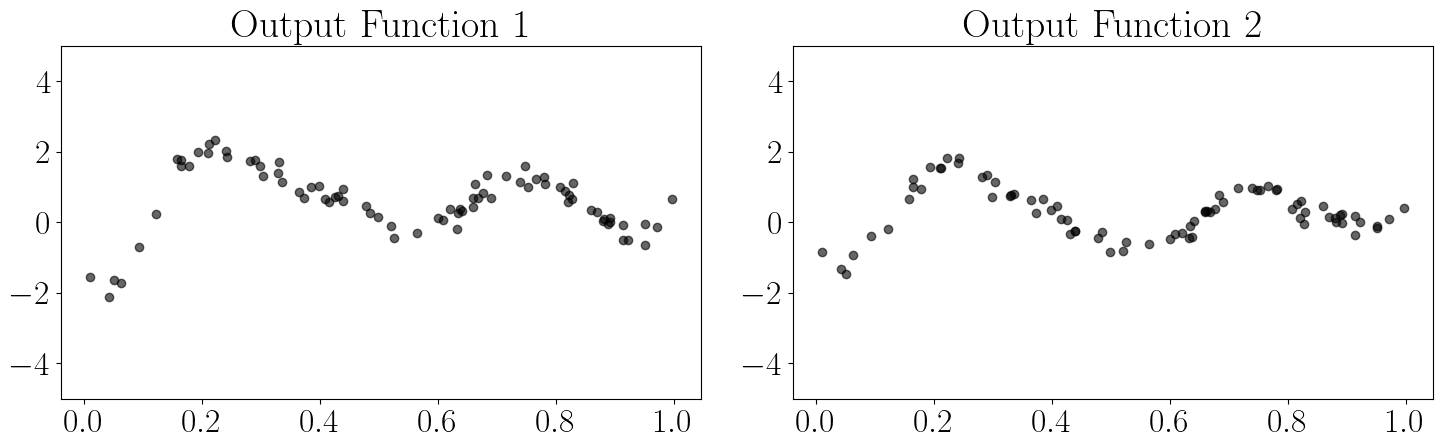

622
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


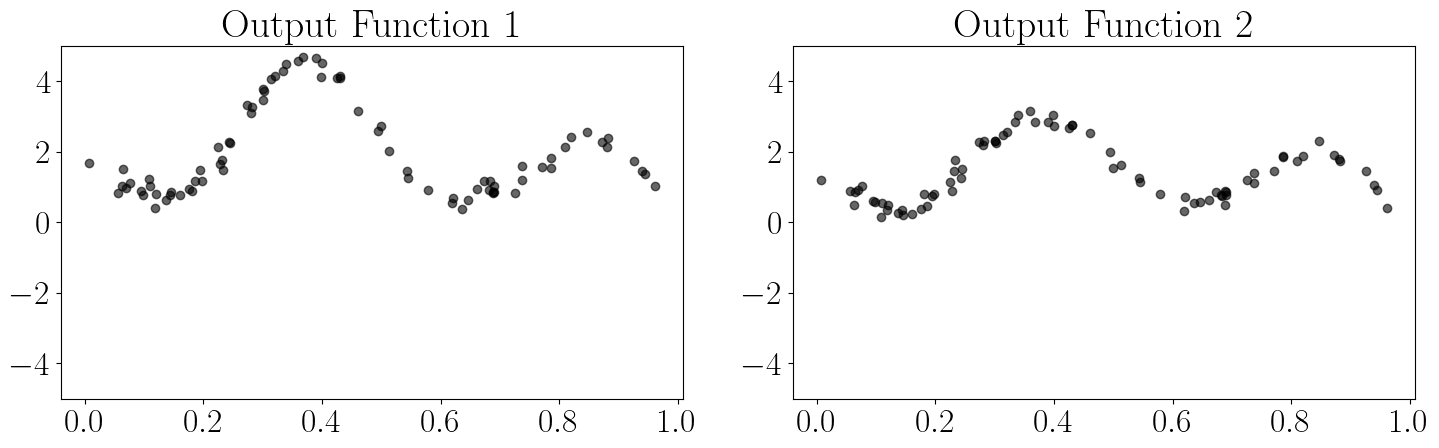

625
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


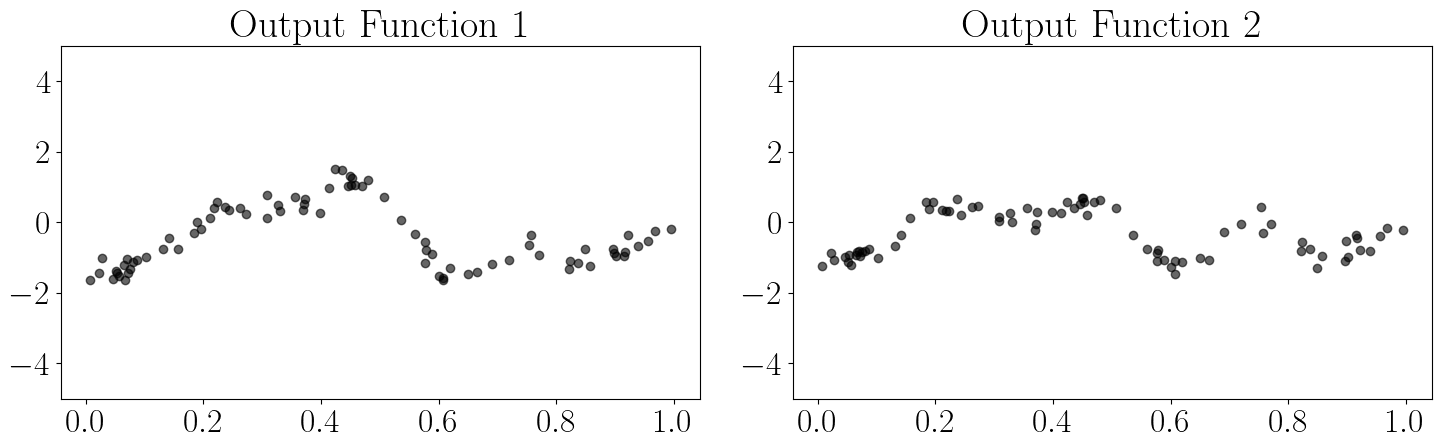

630
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


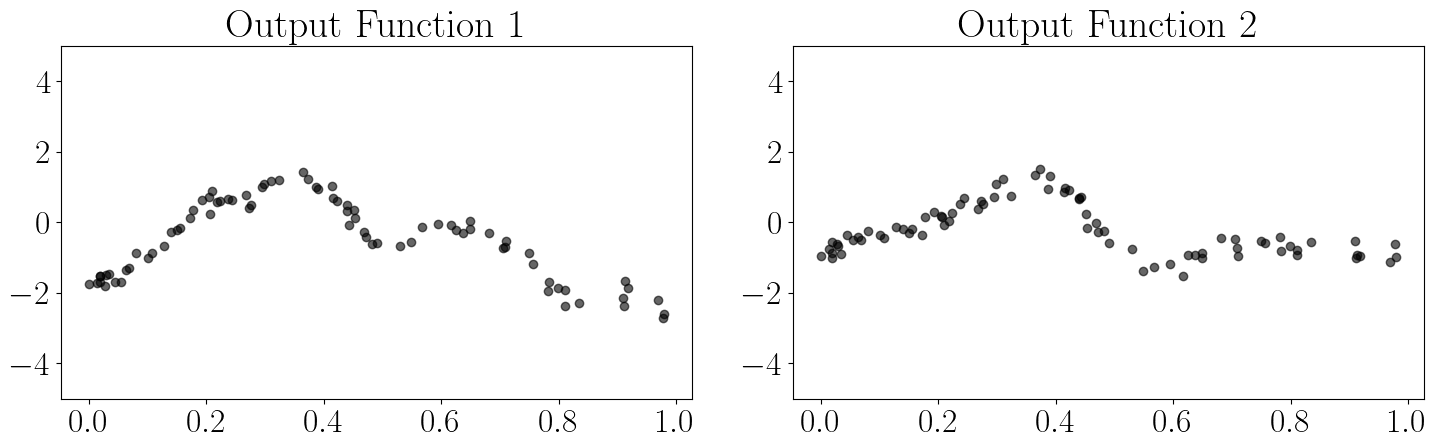

632
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


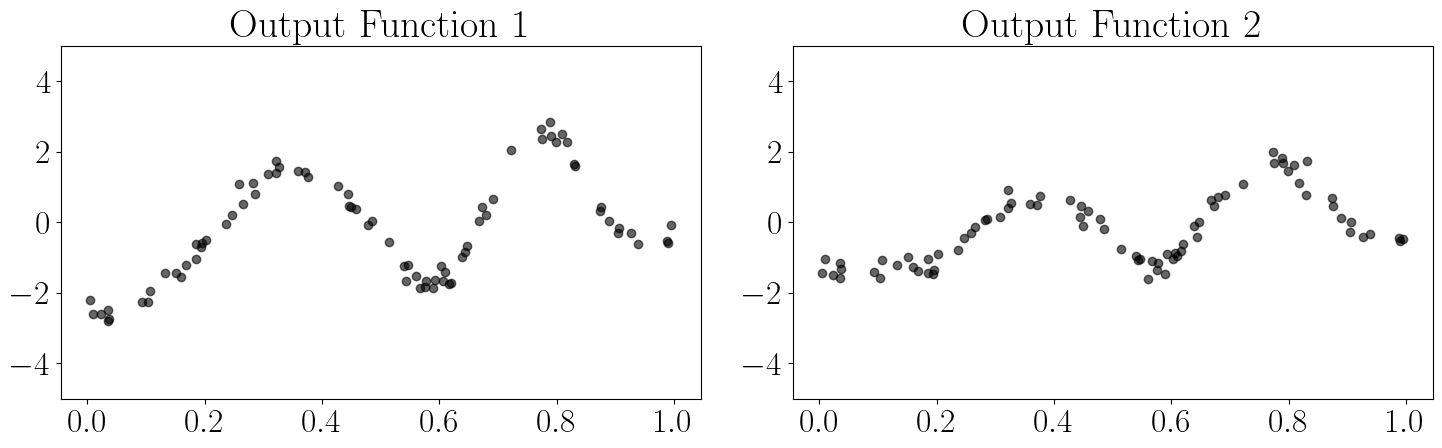

634
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


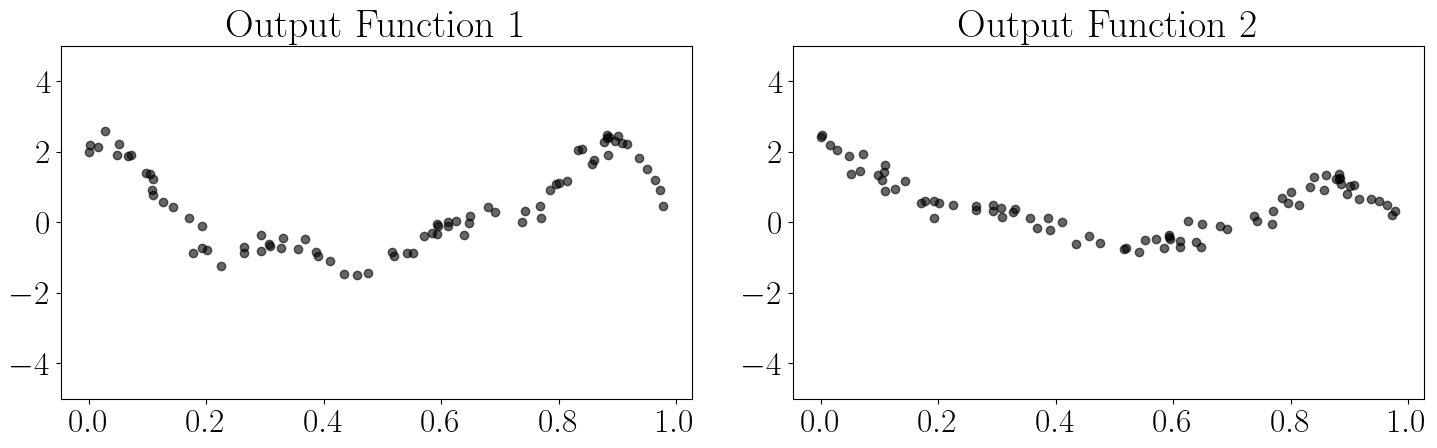

635
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


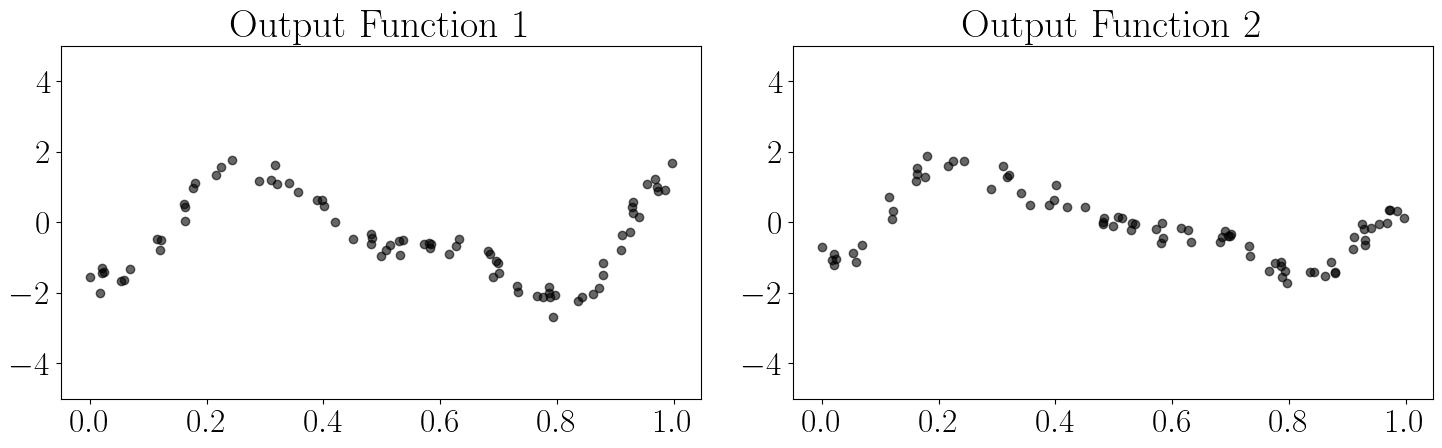

636
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


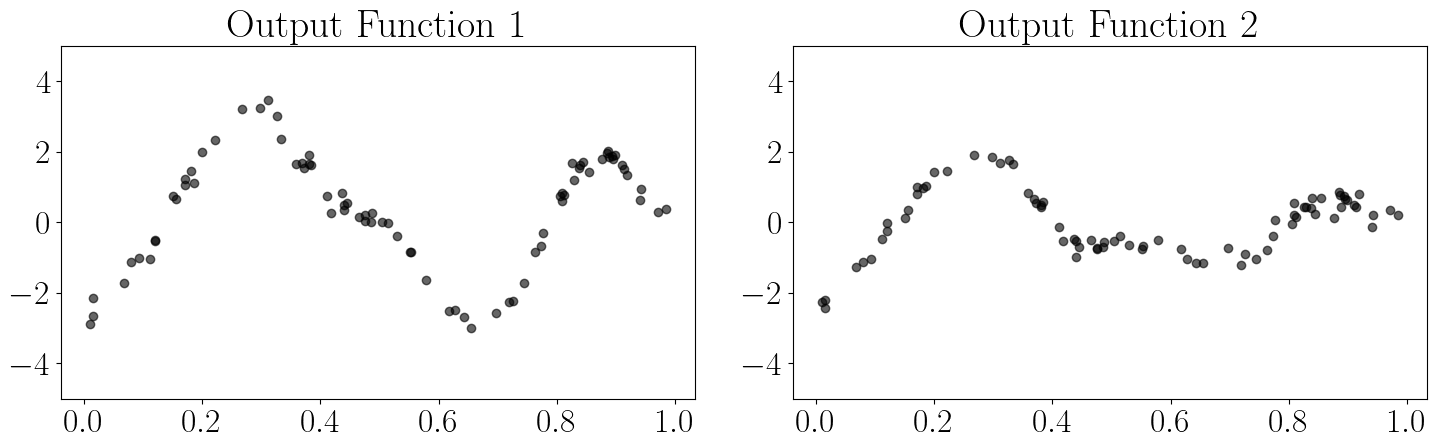

637
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


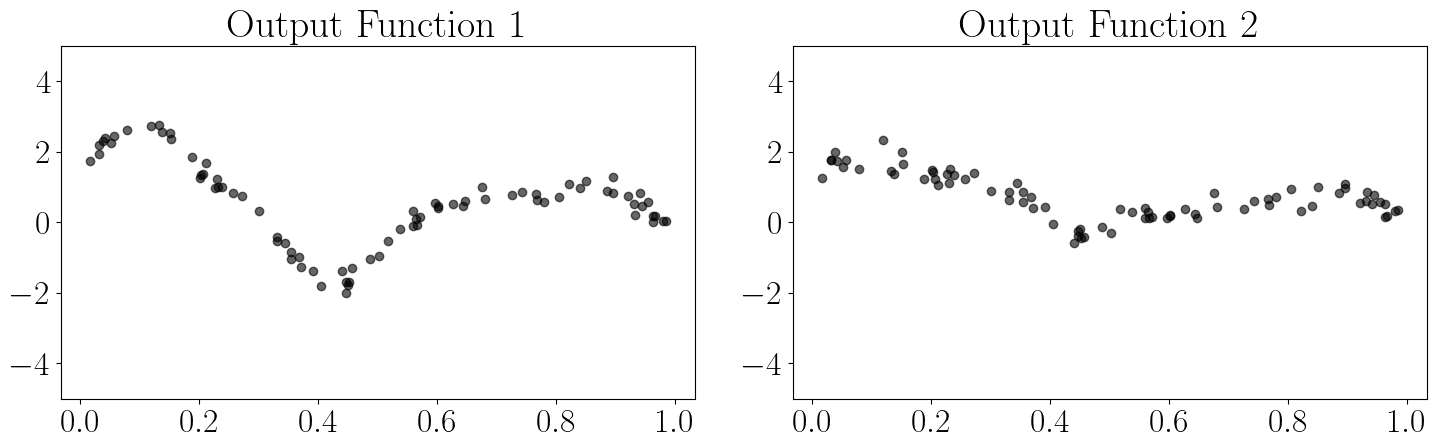

641
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


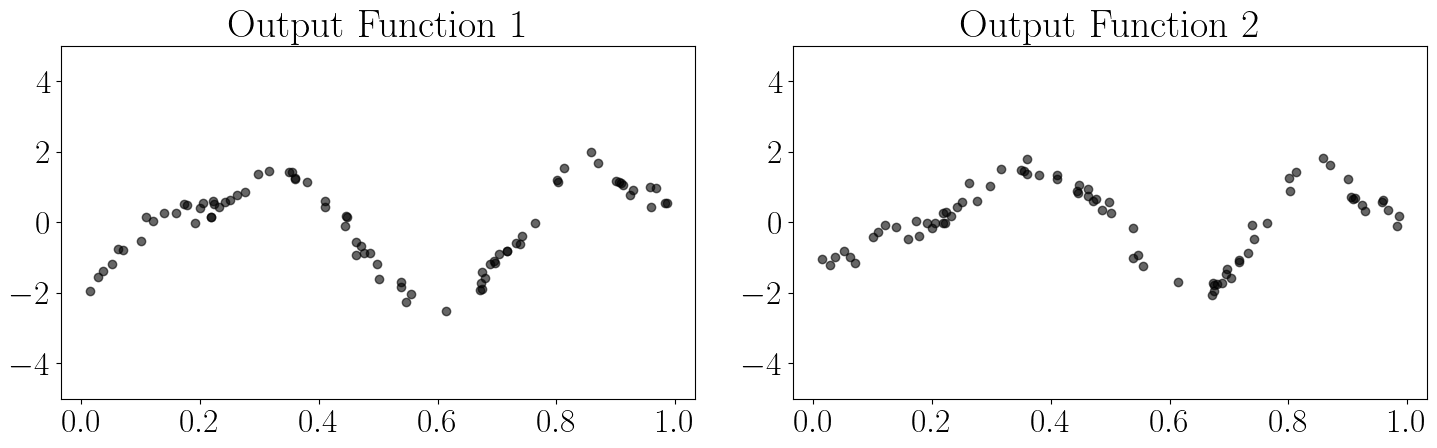

642
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


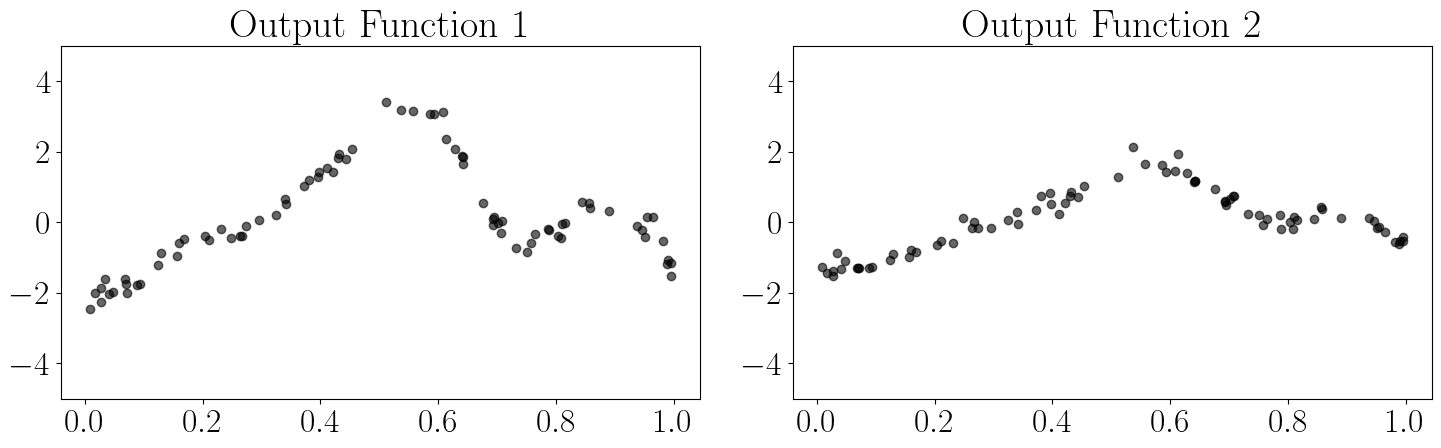

644
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


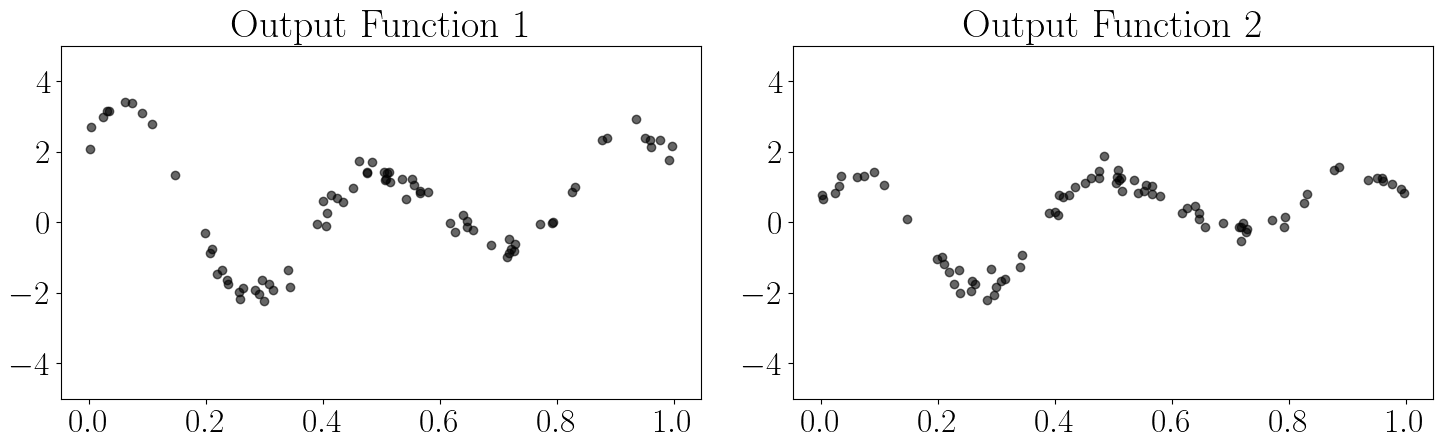

646
[[1.999396 1.249976]
 [1.249976 1.00048 ]]


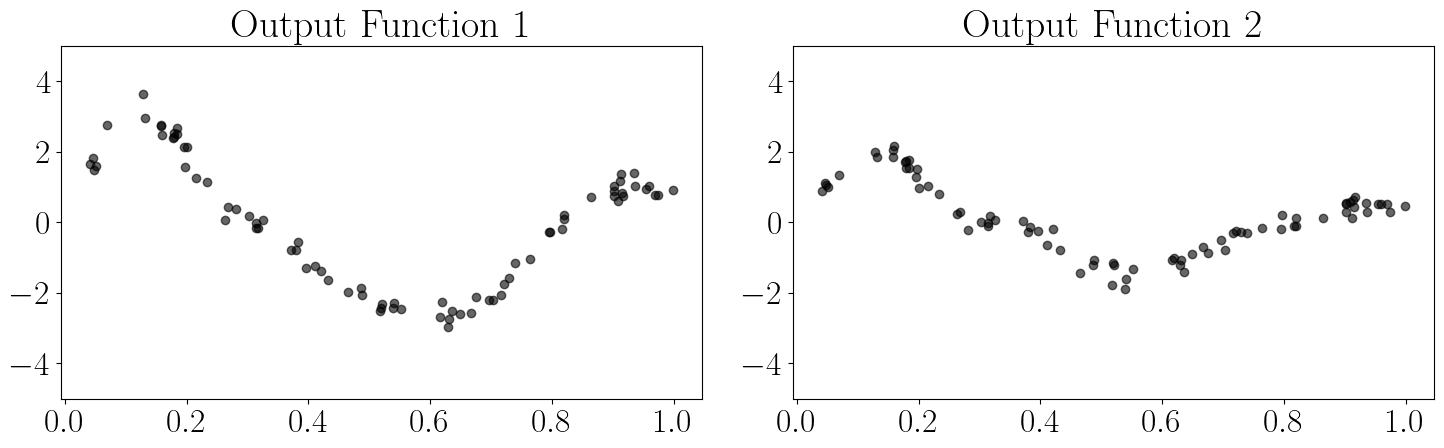

KeyboardInterrupt: 

In [7]:
for i in range(500, 750):
    np.random.seed(i)
    # print(i)
    # Initialisation
    constant_mean = 0
    length_scale = 0.1
    variance = 1
    n_outputs = 2
    n_points = 160
    overlap_ratio = 1

    noise_variance = 0.04

    A = np.array([[1.414, 0], 
        [0.884, 0.468]])
    B = A @ A.T
    # print(B)

    D = B.shape[0]

    # Simulation
    mean_func = ConstantMean(constant=constant_mean)
    rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

    x_train = np.sort(np.random.uniform(0, 1, 80)).reshape(-1, 1)
    N = len(x_train)
    kernel_train = rbf_kernel(x_train, x_train)
    K_train = np.kron(B, kernel_train)
    K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
    y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

    y_train = apply_overlap(y_train, overlap_ratio)

    # indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
    # outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
    # y_train[outlier_indices_025, 0] = 2

    x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

    if np.abs(y_train[0,0]) > 1.5:
        print(i)
        print(B)

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        for i in range(2):
            axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
            axs[i].set_title(f"Output Function {i+1}")
            axs[i].set_ylim([-5, 5])
            # axs[i].legend()

        plt.tight_layout()
        plt.show()

[[1.999396 1.200486]
 [1.200486 1.000642]]


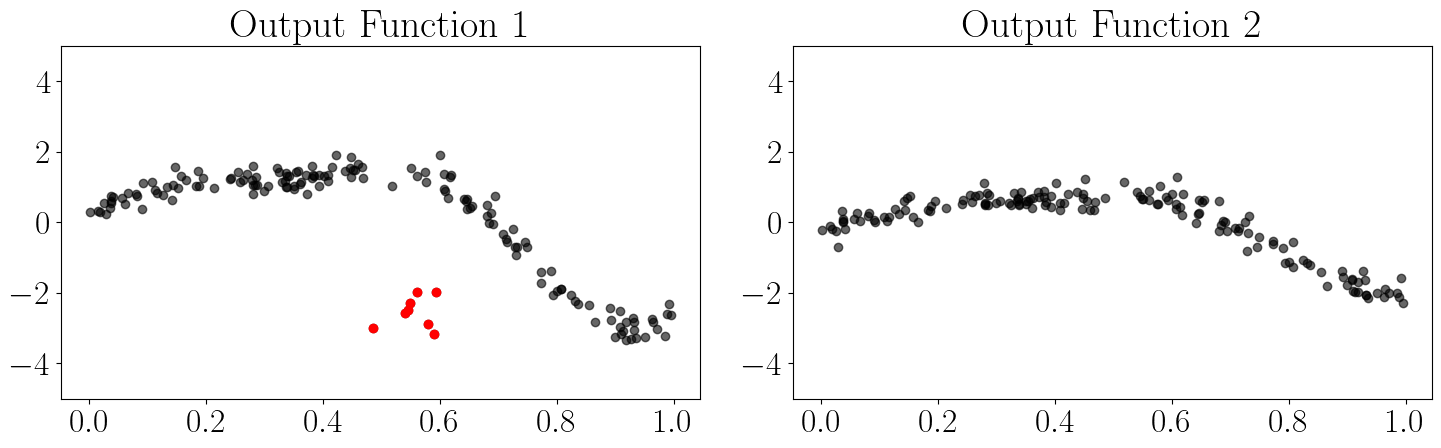

In [174]:
np.random.seed(48)
# Initialisation
epsilon = 0.05
constant_mean = 0
length_scale = 0.2
variance = 1
n_outputs = 2
n_points = 160
overlap_ratio = 1

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

noise1 = 0.05
noise2 = 0.05
noise = np.array([noise1, noise2])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.sort(np.random.uniform(0, 1, n_points)).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

outlier_range = np.where((x_train >= 0.48) & (x_train <= 0.6))[0]
outlier_indices = np.random.choice(outlier_range, int(epsilon*n_points), replace=False)
y_train[outlier_indices, 0] = np.random.normal(loc=-3, scale=0.5, size=outlier_indices.shape[0])

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

y_train -= np.mean(y_train, axis=0)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-5, 5])
    # axs[i].legend()

plt.tight_layout()
plt.show()

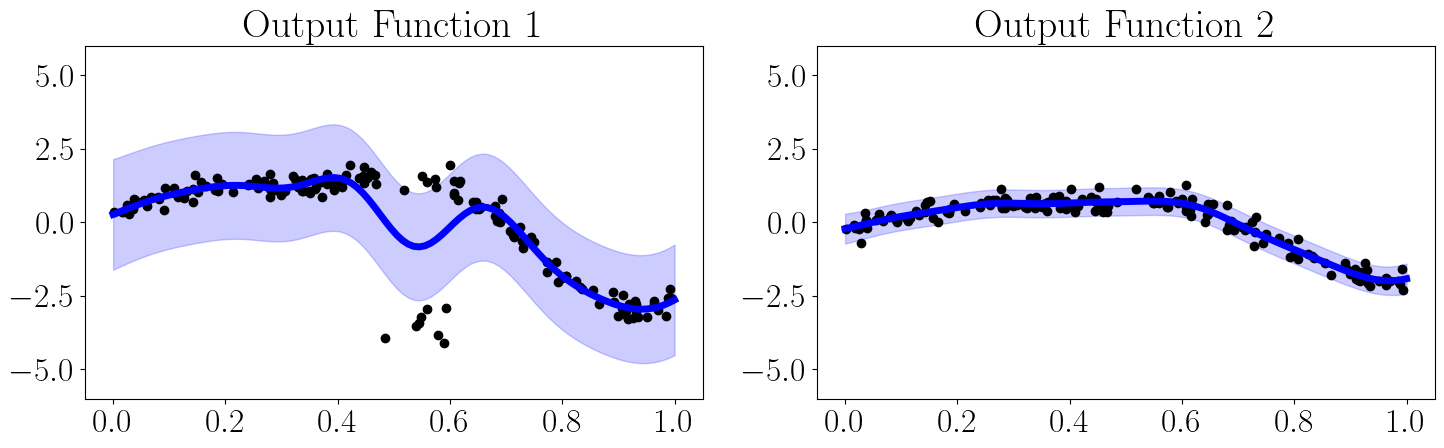

In [168]:
# Instantiate and train
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
# mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_length_scale = mogp.length_scale
optim_B = mogp.B
optim_A = mogp.A
optim_noise = mogp.noise

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='blue', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

-155.90442861756054
-155.90442860411304
-155.90442903763613
-155.90442871493954
-155.90442862872874
-155.90442862292178
-155.90442862741673
-155.90442860775636
-142.7737898224383
-142.7737898564369
-142.77378956084874
-142.77378974907043
-142.7737898124779
-142.77378982970205
-142.77378984234392
-142.7737898240999
-139.2375017480719
-139.23750176039653
-139.23750182390907
-139.23750175192038
-139.2375017429245
-139.2375017548491
-139.23750176663117
-139.23750174803854
-138.819058191147
-138.8190582024584
-138.81905820317988
-138.81905819024877
-138.81905818559636
-138.81905819736227
-138.81905820927267
-138.81905819279166
Optimized length_scale: 0.0972
Optimized noise: [0.39717266 0.04473722]
Optimized A: [[ 1.50893444 -0.14560721]
 [ 0.41894388  0.51082844]]
Optimized B: 
[[2.29808461 0.55777855]
 [0.55777855 0.43645967]]


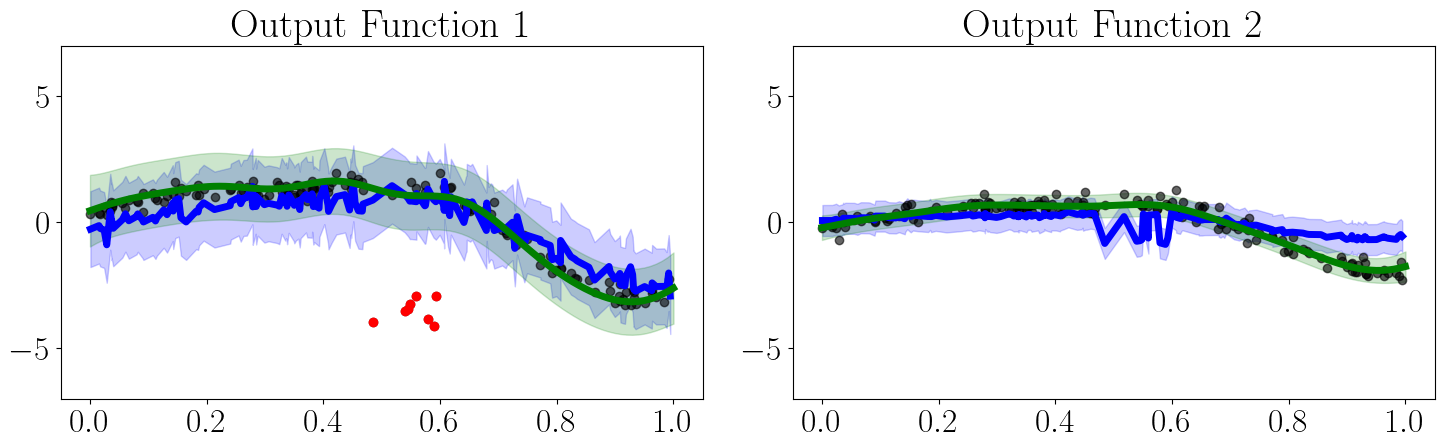

In [169]:
# Instantiate and train
# morcgp = MORCGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=optim_A)
# predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train, B_weighted=optim_B, noise_weighted=optim_noise)

# print(morcgp.loo_cv(length_scale=length_scale, noise=np.array([0.05, 0.05]), A=A, weighted=True))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

length_scale_morcgp = morcgp.length_scale
A_morcgp = morcgp.A


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')

    axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='green', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-7, 7])

plt.tight_layout()
plt.show()

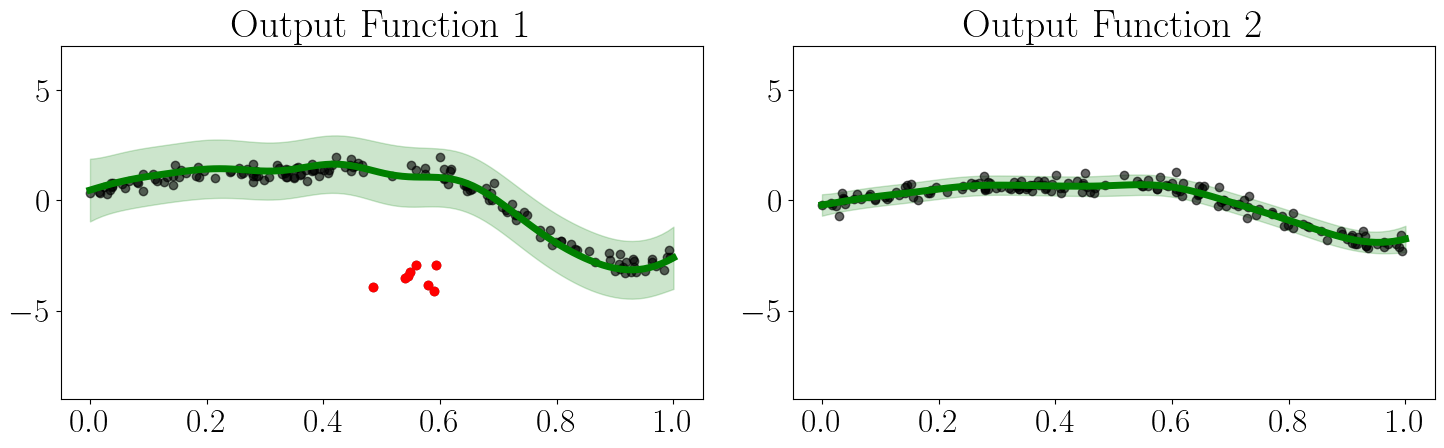

In [170]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='green', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-9, 7])

plt.tight_layout()
plt.show()

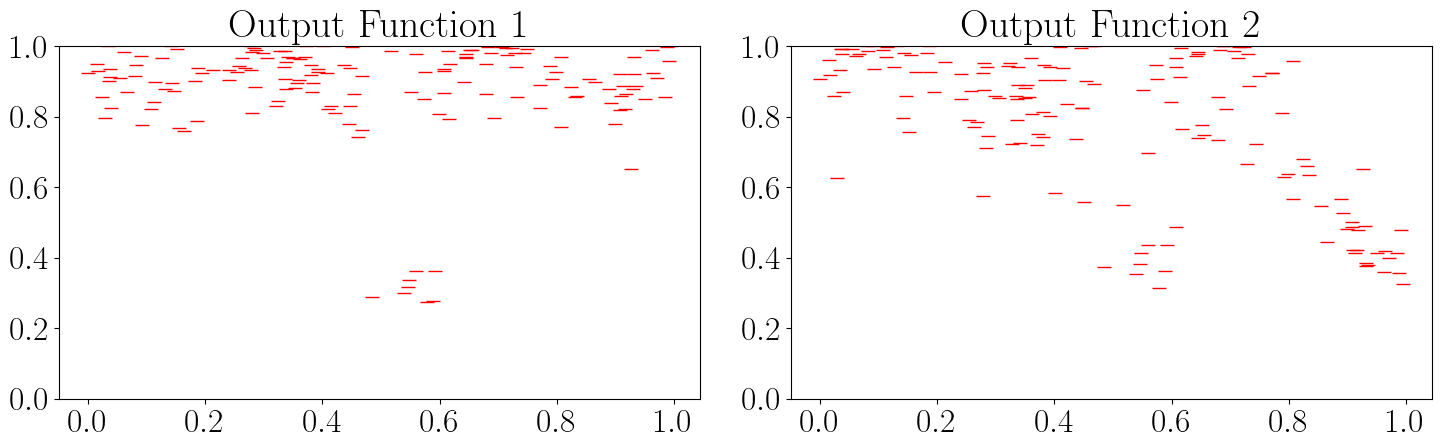

In [171]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):

    axs[i].plot(x_train.flatten(), ((morcgp.w01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()

Optimized length_scale: 0.0587, noise: 0.746536, rbf_variance: 0.8578
Optimized length_scale: 0.2276, noise: 0.050039, rbf_variance: 0.5366


(-9.0, 7.0)

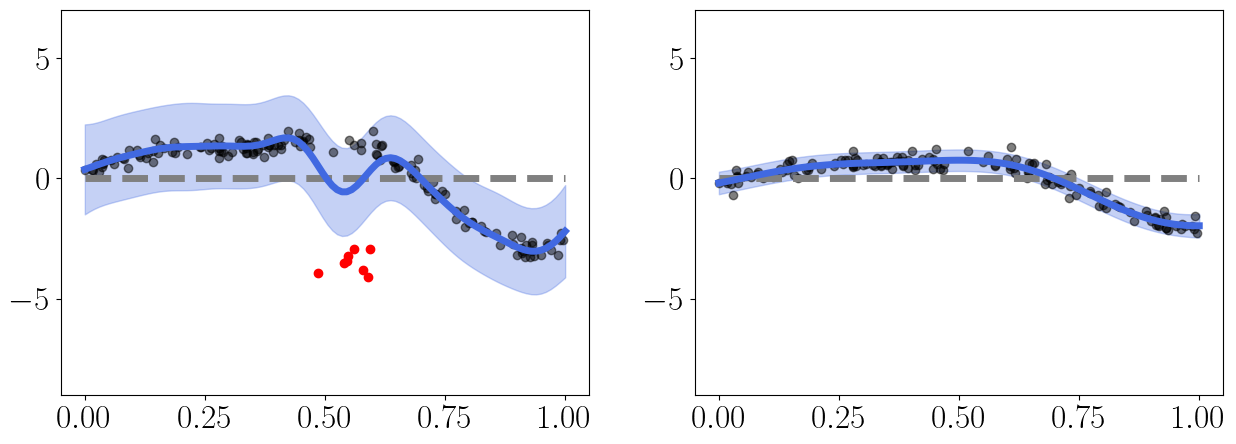

In [172]:
y_train1, y_train2 = y_train[:, 0].reshape(-1,1), y_train[:, 1].reshape(-1,1)

mu_rcgp = np.full((len(x_test), 2), np.nan)
std_rcgp = np.full((len(x_test), 2), np.nan)

# Plot 1 ------------------

constant_mean = ConstantMean(constant=0)
rcgp1 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=noise1, epsilon=epsilon)
rcgp1.fit(x_train, y_train1)
rcgp1.optimize_loo_cv(weighted=False, print_opt_param=True)

mu_rcgp[:, 0], var_rcgp = rcgp1.predict(x_test)
std_rcgp[:, 0] = np.sqrt(var_rcgp + rcgp1.noise)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(x_train[mask], y_train1[mask], 'o', color='black', alpha=0.5)
axs[0].plot(x_train[~mask], y_train1[~mask], 'o', color='red')
axs[0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0].plot(x_test, mu_rcgp[:, 0].ravel(), color="royalblue")
axs[0].fill_between(x_test.ravel(), mu_rcgp[:, 0].ravel() - 1.96 * std_rcgp[:, 0], mu_rcgp[:, 0].ravel() + 1.96 * std_rcgp[:, 0], alpha=0.3, color='royalblue')
axs[0].set_ylim([-9, 7])

# Plot 2 ------------------

rcgp2 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=noise2, epsilon=epsilon)
rcgp2.fit(x_train, y_train2)
rcgp2.optimize_loo_cv(weighted=False, print_opt_param=True)

mu_rcgp[:, 1], var2 = rcgp2.predict(x_test)
std_rcgp[:, 1] = np.sqrt(var2 + rcgp2.noise)

axs[1].plot(x_train[mask], y_train2[mask], 'o', color='black', alpha=0.5)
# axs[1].plot(x_train[~mask], y_train2[~mask], 'o', color='red')
axs[1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1].plot(x_test, mu_rcgp[:, 1].ravel(), color="royalblue")
axs[1].fill_between(x_test.ravel(), mu_rcgp[:, 1].ravel() - 1.96 * std_rcgp[:, 1], mu_rcgp[:, 1].ravel() + 1.96 * std_rcgp[:, 1], alpha=0.3, color='royalblue')
axs[1].set_ylim([-9, 7])


-550.3553023041375
-550.3553029300335
-550.3552967722408
-550.3553022962043
-550.3553022332699
-550.355302341272
-550.3553023765473
-550.3553022786357
-224.99033704516233
-224.99033713105018
-224.9903354540652
-224.99033703624943
-224.99033702602094
-224.99033706036263
-224.99033708640687
-224.99033704448388
-177.242427404923
-177.24242743137904
-177.24242657583488
-177.24242739830066
-177.24242739316827
-177.2424274169017
-177.24242744094255
-177.24242740725896
-153.63284146215125
-153.63284145766056
-153.63284118049518
-153.63284146050233
-153.63284145575767
-153.63284147199016
-153.63284149394536
-153.6328414654953
-149.4580261359634
-149.45802612785562
-149.45802605754724
-149.45802613709216
-149.45802613140626
-149.45802614499743
-149.4580261659579
-149.45802613949692
-148.8828279149858
-148.88282791009385
-148.88282790834347
-148.88282791599855
-148.8828279109453
-148.88282792323918
-148.88282794360785
-148.88282791991284
Optimized length_scale: 0.0910
Optimized noise: [0.4325475

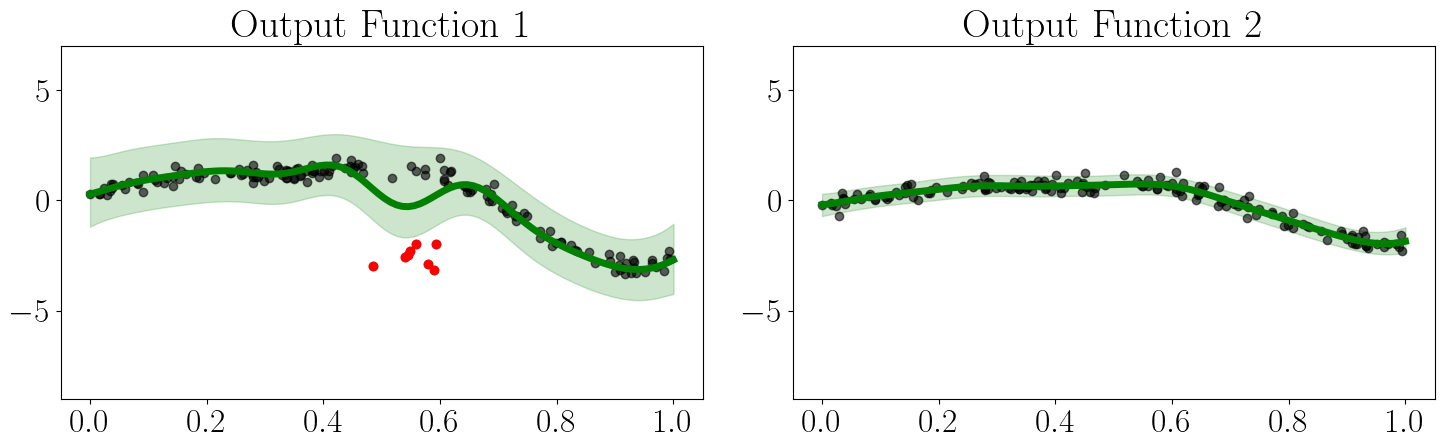

In [178]:
morcgp = MORCGPRegressor_PM(mean = 0, length_scale=optim_length_scale, noise = noise, A=optim_A, epsilons=np.array([epsilon, 0]))
morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )


# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_pm, var_pm = morcgp.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')

    axs[i].plot(x_test.flatten(), mu_pm[:, i], '-', color='green', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_morcgp[:, i] + 2*std_pm[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-9, 7])

plt.tight_layout()
plt.show()

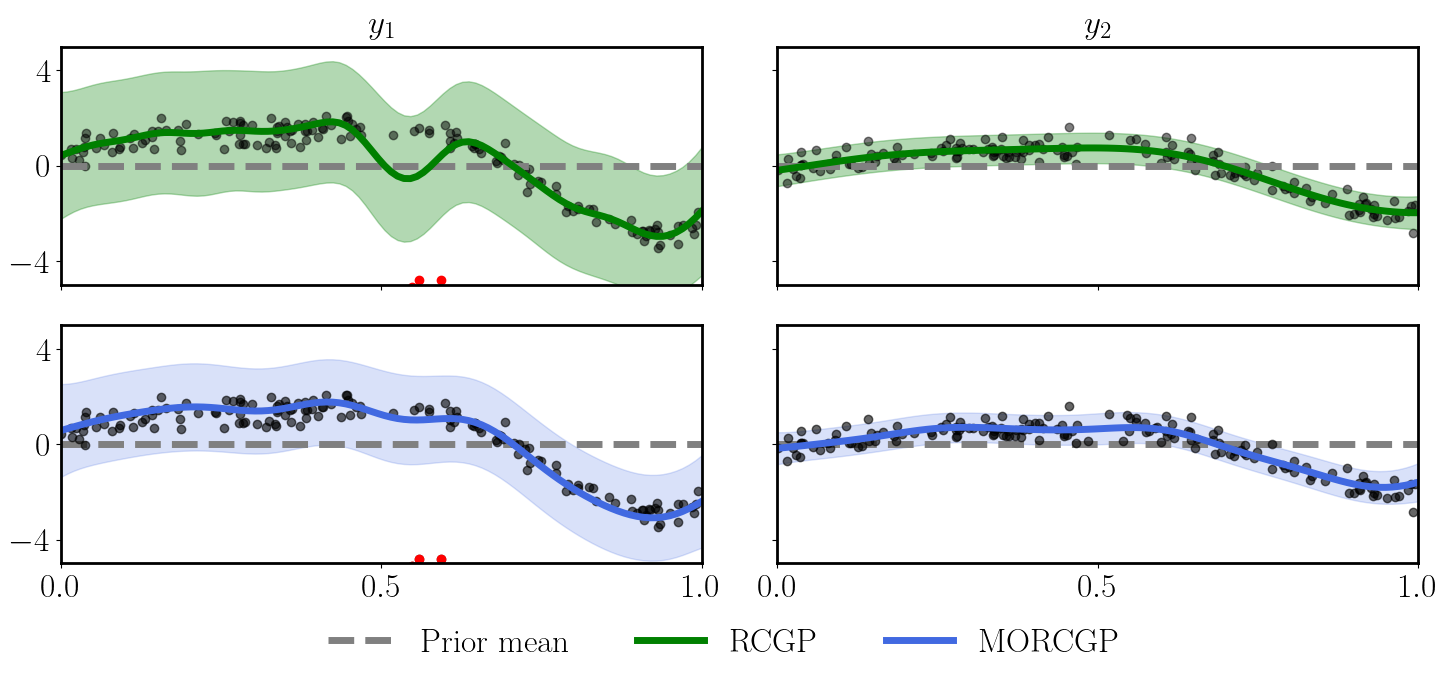

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

# -------- Plot 1: RCGP on y_train1 --------
constant_mean = ConstantMean(constant=0)
rcgp1 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=0.04, epsilon=epsilon)
rcgp1.fit(x_train, y_train[:, 0].reshape(-1,1))
rcgp1.optimize_loo_cv(weighted=False, print_opt_param=False)

mu1, var1 = rcgp1.predict(x_test)
std1 = np.sqrt(var1 + rcgp1.noise)

axs[0, 0].plot(x_train[mask], y_train[mask, 0], 'o', color='black', alpha=0.5)
axs[0, 0].plot(x_train[~mask], y_train[~mask, 0], 'o', color='red')
axs[0, 0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0, 0].plot(x_test, mu1.ravel(), color="green")
axs[0, 0].fill_between(x_test.ravel(), mu1.ravel() - 1.96 * std1, mu1.ravel() + 1.96 * std1, alpha=0.3, color='green')
axs[0, 0].set_title('$y_1$', fontsize=24, pad=10)

# -------- Plot 2: RCGP on y_train2 --------
rcgp2 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=0.04, epsilon=epsilon)
rcgp2.fit(x_train, y_train[:, 1].reshape(-1,1))
rcgp2.optimize_loo_cv(weighted=False, print_opt_param=False)

mu2, var2 = rcgp2.predict(x_test)
std2 = np.sqrt(var2 + rcgp2.noise)

axs[0, 1].plot(x_train[mask], y_train[mask, 1], 'o', color='black', alpha=0.5)
# axs[0, 1].plot(x_train[~mask], y_train[~mask, 1], 'o', color='red')
axs[0, 1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0, 1].plot(x_test, mu2.ravel(), color="green", label='RCGP')
axs[0, 1].fill_between(x_test.ravel(), mu2.ravel() - 1.96 * std2, mu2.ravel() + 1.96 * std2, alpha=0.3, color='green')
axs[0, 1].set_title('$y_2$', fontsize=24, pad=10)
# axs[0, 1].legend()

# -------- Plot 3: Multi-output prediction for y_train1 --------
axs[1, 0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1, 0].plot(x_train.flatten(), y_train[:, 0], 'o', color='black', alpha=0.6)
axs[1, 0].plot(x_train.flatten()[~mask], y_train[:, 0][~mask], 'o', color='red')
axs[1, 0].plot(x_test.flatten(), mu_morcgp[:, 0], '-', color='royalblue', label='MORCGP')
axs[1, 0].fill_between(x_test.flatten(), mu_morcgp[:, 0] - 2*std_morcgp[:, 0], mu_morcgp[:, 0] + 2*std_morcgp[:, 0], color='royalblue', alpha=0.2)

# -------- Plot 4: Multi-output prediction for y_train2 --------
axs[1, 1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1, 1].plot(x_train.flatten(), y_train[:, 1], 'o', color='black', alpha=0.6)
axs[1, 1].plot(x_test.flatten(), mu_morcgp[:, 1], '-', color='royalblue', label='MORCGP')
axs[1, 1].fill_between(x_test.flatten(), mu_morcgp[:, 1] - 2*std_morcgp[:, 1], mu_morcgp[:, 1] + 2*std_morcgp[:, 1], color='royalblue', alpha=0.2)
# axs[1, 1].legend()

for ax in axs.flat:
    ax.set_ylim([-5, 5])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim([0, 1])
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

# Show y-ticks only with labels on left plots, hide labels on right
for i in range(2):
    axs[i, 0].set_yticks([-4, 0, 4])          # Left: ticks and labels
    axs[i, 1].set_yticks([-4, 0, 4])          # Right: ticks only
    axs[i, 1].set_yticklabels([])             # Right: no labels

# for ax in axs[:, 0]:
#     ax.set_ylabel('$y_1$', fontsize=24, rotation=0, labelpad=10, va='center', ha='right')

# for ax in axs[:, 1]:
#     ax.set_ylabel('$y_2$', fontsize=24, rotation=0, labelpad=25, va='center', ha='left')

for ax in axs[0, :]:
    ax.set_xticklabels([])  # Remove the x-axis labels but keep the ticks


import matplotlib.lines as mlines

# Create custom legend handles
prior_mean_line = mlines.Line2D([], [], color='grey', linestyle='--', label='Prior mean')
rcgp_line = mlines.Line2D([], [], color='green', linestyle='-', label='RCGP')
morcgp_line = mlines.Line2D([], [], color='royalblue', linestyle='-', label='MORCGP')

# Place legend below all subplots, centered, 1 row, 3 columns
fig.legend(handles=[prior_mean_line, rcgp_line, morcgp_line],
           loc='lower center', bbox_to_anchor=(0.5, -0.02),
           ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend
plt.show()

# fig.savefig("./results/synthetic_MOGP_MORCGP.pdf", format='pdf', bbox_inches='tight')

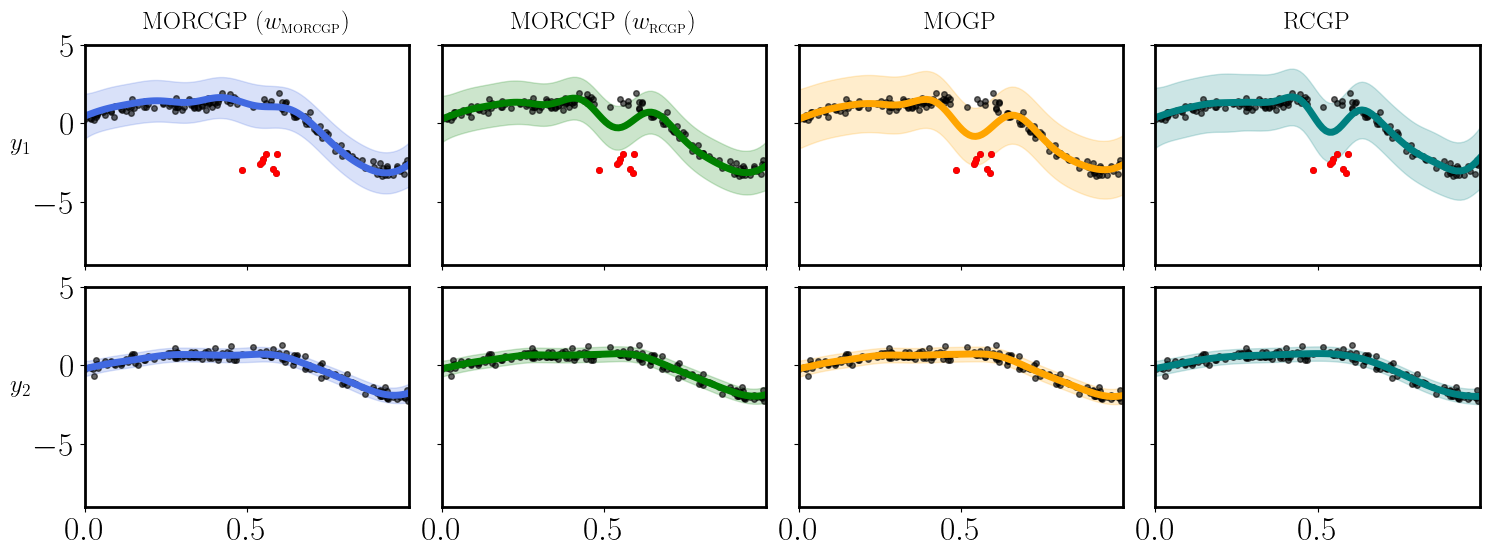

In [206]:
# Create a 2x4 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

# Plot 1: MORCGP with MORCGP weights

for i, ax in enumerate(axes[:2, 0]):
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4, label=f'Output {i+1}')
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outlier points')

    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MORCGP')
    ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='royalblue', alpha=0.2)

    ax.set_ylim([-9, 5])
    ax.set_xlim([0, 1])

# Plot 2: MORCGP with RCGP weights
for i, ax in enumerate(axes[:2, 1]):
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4, label=f'Output {i+1}')
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outlier points')

    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='green', label='RCGP')
    ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='green', alpha=0.2)

    ax.set_ylim([-9, 5])
    ax.set_xlim([0, 1])

# Plot 3: MOGP
for i, ax in enumerate(axes[:2, 2]):
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4, label=f'Output {i+1}')
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outlier points')

    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='orange', label='MOGP')
    ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='orange', alpha=0.2)

    ax.set_ylim([-9, 5])
    ax.set_xlim([0, 1])

# Plot 4: RCGP
for i, ax in enumerate(axes[:2, 3]):
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4, label=f'Output {i+1}')
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outlier points')

    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='teal', label='RCGP')
    ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='teal', alpha=0.2)

    ax.set_ylim([-9, 5])
    ax.set_xlim([0, 1])

# Hide y-tick labels for all but the leftmost column
for row in range(2):
    for col in range(1, 4):
        axes[row, col].set_yticklabels([])

# Optionally, set y-ticks only on the leftmost column for clarity
for row in range(2):
    axes[row, 0].yaxis.set_tick_params(labelleft=True)
    # Remove x-axis tick labels from the top row
    for ax in axes[0, :]:
        ax.set_xticklabels([])
    # Ensure x-axis tick labels are shown only on the bottom row
    for ax in axes[1, :]:
        ax.xaxis.set_tick_params(labelbottom=True)

for row in range(2):
    for col in range(4):
        axes[row, col].set_xticks([0, 0.5])

        # Make all axes borders thicker
        for row in range(2):
            for col in range(4):
                for spine in axes[row, col].spines.values():
                    spine.set_linewidth(2)

                    # Set y-axis titles for the leftmost column
                    axes[0, 0].set_ylabel('$y_1$', fontsize=18, labelpad=10, rotation=0)
                    axes[1, 0].set_ylabel('$y_2$', fontsize=18, labelpad=10, rotation=0)
        
        # Set column titles
        titles = [r"MORCGP ($w_{\scriptscriptstyle\textrm{MORCGP}}$)", r"MORCGP ($w_{\scriptscriptstyle\textrm{RCGP}}$)", "MOGP", "RCGP"]
        for col, title in enumerate(titles):
            axes[0, col].set_title(title, fontsize=18, pad=12)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.tight_layout()
plt.show()
# Set x-ticks and y-ticks to [0, 0.5] for all axes